In [1]:
import os
import numpy as np
import numpy.random as rd
import scipy as sp
from scipy import stats as st
from collections import Counter

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]
%matplotlib inline

%config InlineBackend.figure_format='retina'
# OS判別 ======================
flag_win32 = False
try:
    os.uname()
except AttributeError:
    flag_win32 = True

# Mac用フォント設定
if not flag_win32:
    font_path = '/Library/Fonts/Osaka.ttf'
    font_prop = font_manager.FontProperties(fname=font_path)
    matplotlib.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['font.family'] = 'Osaka'


In [2]:
def calc_likelihood(data, mu, sigma, pi, K):
    likelihood = np.zeros((np.sum(n), 3))
    for k in range(K):
        likelihood[:, k] = [pi[k]*st.multivariate_normal.pdf(d, mu[k], sigma[k]) for d in data]
    return likelihood

def calc_prob_gmm(data, mu, sigma, pi, K):
    return [[pi[k]*st.multivariate_normal.pdf(d, mu[k], sigma[k]) for k in range(K)] for d in data]

def print_gmm_contour(mu, sigma, pi, K):
    from matplotlib.colors import LogNorm
    # display predicted scores by the model as a contour plot
    X, Y = np.meshgrid(np.linspace(min_x, max_x), np.linspace(min_y, max_y))
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = np.sum(np.asanyarray(calc_prob_gmm(XX, mu, sigma, pi, K)), axis=1)
    Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z, alpha=0.2, zorder=-100)
    
    plt.title('pdf contour of a GMM')

check:  0 [ 0.2  0.5] [[ 0.1    0.085]
 [ 0.085  0.1  ]] 0.002775
check:  1 [ 1.2  0.5] [[ 0.1   -0.085]
 [-0.085  0.1  ]] 0.002775
check:  2 [ 2.   0.5] [[ 0.1    0.085]
 [ 0.085  0.1  ]] 0.002775


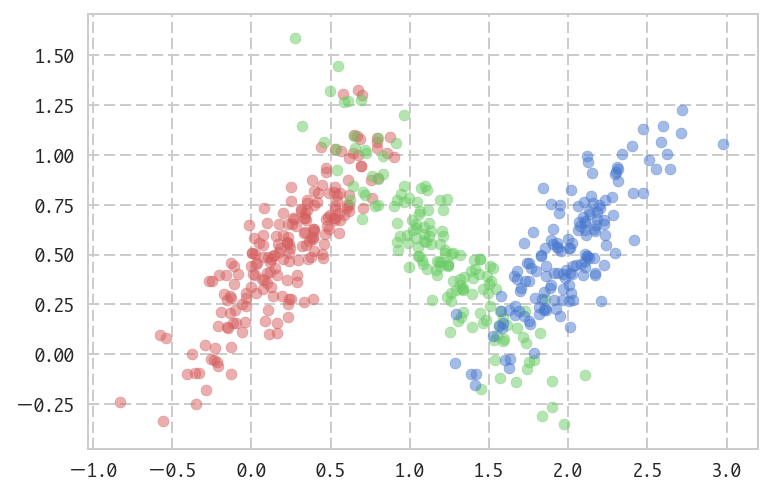

In [3]:
seed = 77
D = 2
n = [200, 150, 150]
N = np.sum(n)
mu_true = np.asanyarray(
     [[0.2, 0.5],
      [1.2, 0.5],
      [2.0, 0.5]])

D = mu_true.shape[1]

sigma_true = np.asanyarray(
        [ [[0.1,  0.085],[ 0.085, 0.1]],
          [[0.1, -0.085],[-0.085, 0.1]],
          [[0.1,  0.085],[ 0.085, 0.1]]
        ])
c = ['r', 'g', 'b']

rd.seed(seed)
org_data = None #np.empty((np.sum(n), 3))
for i in range(3):
    print("check: ", i, mu_true[i], sigma_true[i], np.linalg.det(sigma_true[i]))
    #org_data.append(st.multivariate_normal.rvs(mean=mu[i], cov=sigma[i], size=n[i]))
    if org_data is None:
        org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
    else:
        org_data = np.r_[org_data, np.c_[st.multivariate_normal.rvs(mean=mu_true[i], 
                                                                    cov=sigma_true[i], 
                                                                    size=n[i]), np.ones(n[i])*i]]
        
# plot generated data        
for i in range(3):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c=c[i], alpha=0.5)
    
# drop true cluster label
data = org_data[:,0:2].copy()

# Initialize

init pi: [ 0.33333333  0.33333333  0.33333333]
init mu:
 [[ 2.23461734  0.21275208]
 [ 0.603098    0.32835039]
 [-0.33165408  0.21129426]]


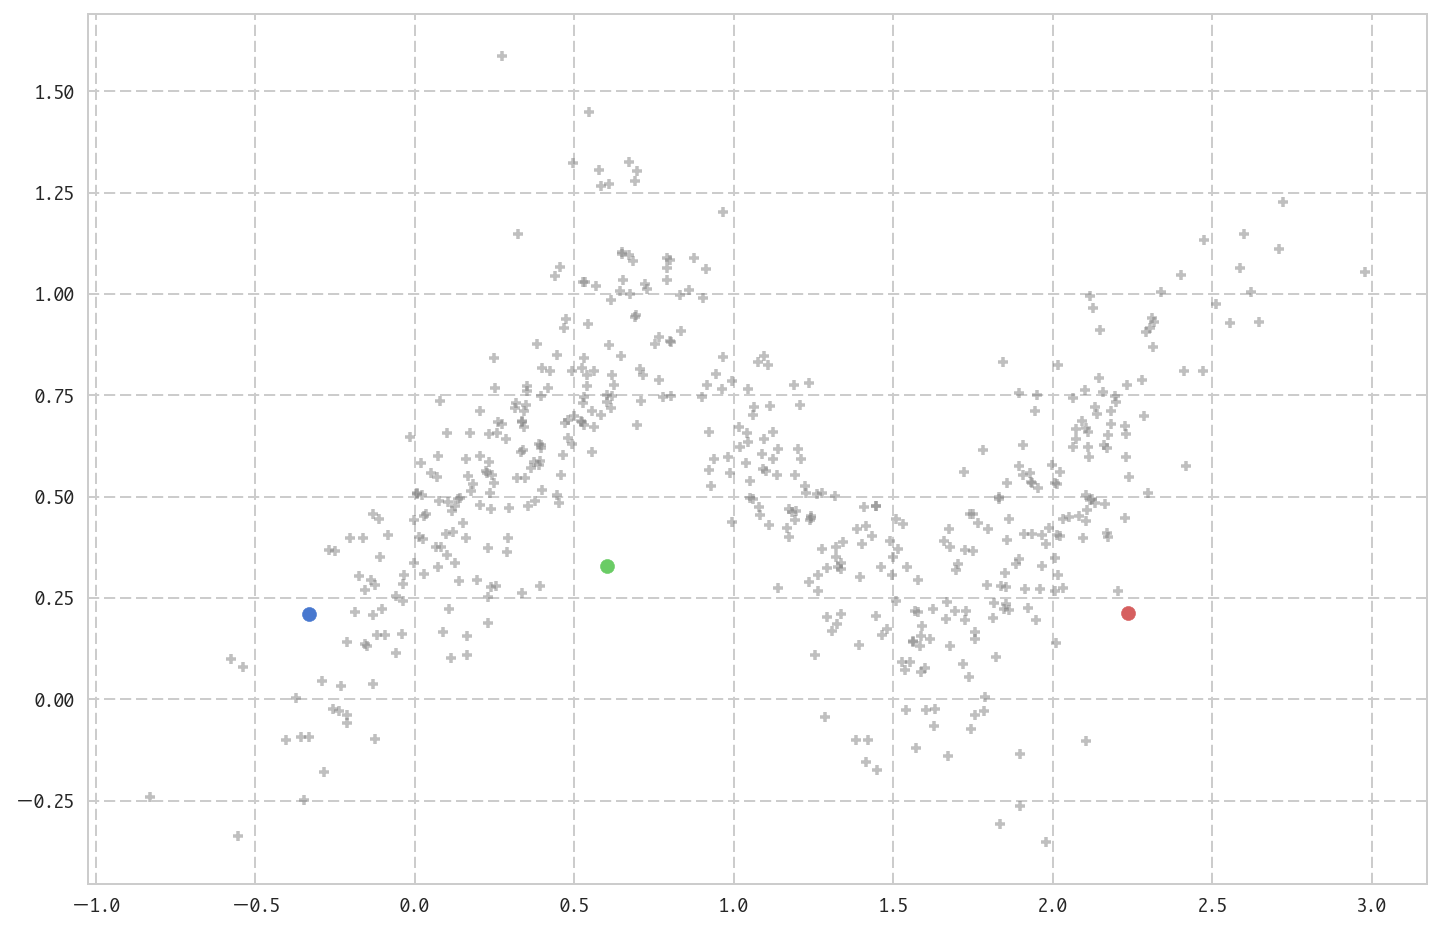

initial sum of log likelihood: -15959.1495777
pi:
 [ 0.33333333  0.33333333  0.33333333]
mu:
 [[ 2.23461734  0.21275208]
 [ 0.603098    0.32835039]
 [-0.33165408  0.21129426]]
sigma:
 [[[ 0.1  0. ]
  [ 0.   0.1]]

 [[ 0.1  0. ]
  [ 0.   0.1]]

 [[ 0.1  0. ]
  [ 0.   0.1]]]


In [4]:

# initialize pi
K = 3
pi = np.zeros(K)
for k in range(K):
    if k == K-1:
        pi[k] = 1 - np.sum(pi)
    else:
        pi[k] = 1/K
print('init pi:', pi)

# initialize mu
max_x, min_x = np.max(data[:,0]), np.min(data[:,0])
max_y, min_y = np.max(data[:,1]), np.min(data[:,1])
mu = np.c_[rd.uniform(low=min_x, high=max_x, size=K), rd.uniform(low=min_y, high=max_y, size=K) ]
print('init mu:\n', mu)

# visualize for check
plt.figure(figsize=(12,8))
plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")

for i in range(3):
    plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
    
plt.show()

# initialize sigma
sigma = np.asanyarray(
        [ [[0.1,  0],[ 0, 0.1]],
          [[0.1,  0],[ 0, 0.1]],
          [[0.1,  0],[ 0, 0.1]] ])

# calculate likelihood
likelihood = calc_likelihood(data, mu, sigma, pi, K)
print('initial sum of log likelihood:', np.sum(np.log(likelihood)))

print('pi:\n', pi)
print('mu:\n', mu)
print('sigma:\n', sigma)

plt.title('initial state')

# EM algorithm started

sum of log likelihood: -28949.449633
diff: 12990.3000553
pi: [ 0.37425622  0.47734472  0.14839906]
mu: [[ 1.92946957  0.43847159]
 [ 0.70882196  0.65462358]
 [-0.06626214  0.27555338]]
sigma: [[[ 0.09619612  0.07009194]
  [ 0.07009194  0.09716098]]

 [[ 0.16528261 -0.02062909]
  [-0.02062909  0.07833795]]

 [[ 0.05343443  0.04434765]
  [ 0.04434765  0.06405165]]]


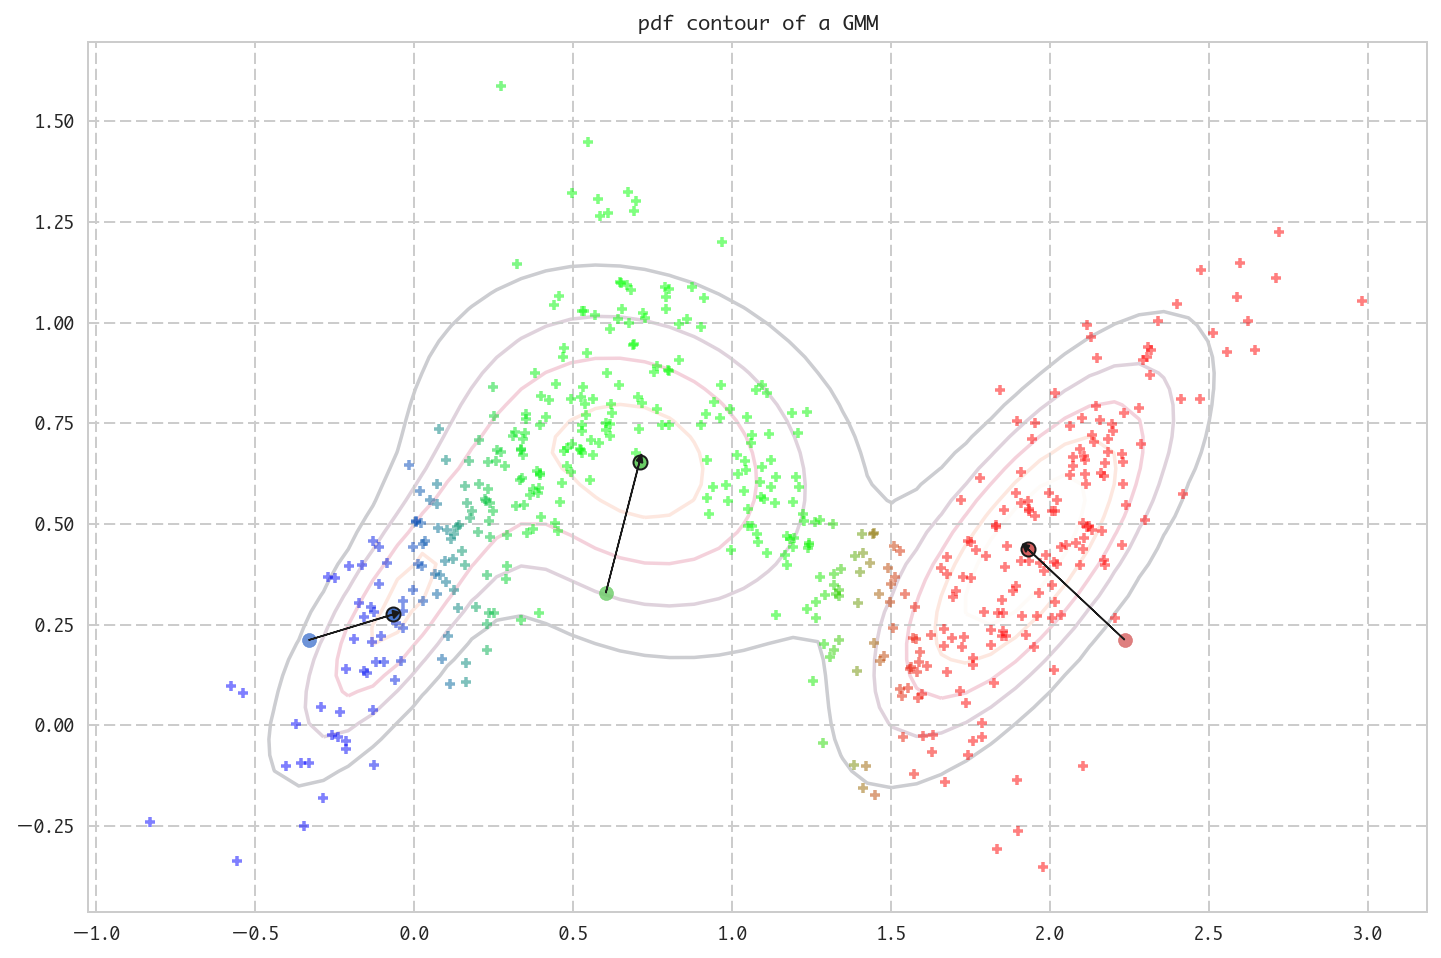

sum of log likelihood: -29483.2972551
diff: 533.847622106
pi: [ 0.37749335  0.44113755  0.18136909]
mu: [[ 1.92023766  0.42813651]
 [ 0.74611943  0.68041833]
 [-0.018653    0.30709161]]
sigma: [[[ 0.1010454   0.07561255]
  [ 0.07561255  0.09999275]]

 [[ 0.15974937 -0.02716048]
  [-0.02716048  0.07148596]]

 [[ 0.05744736  0.04716718]
  [ 0.04716718  0.06190521]]]


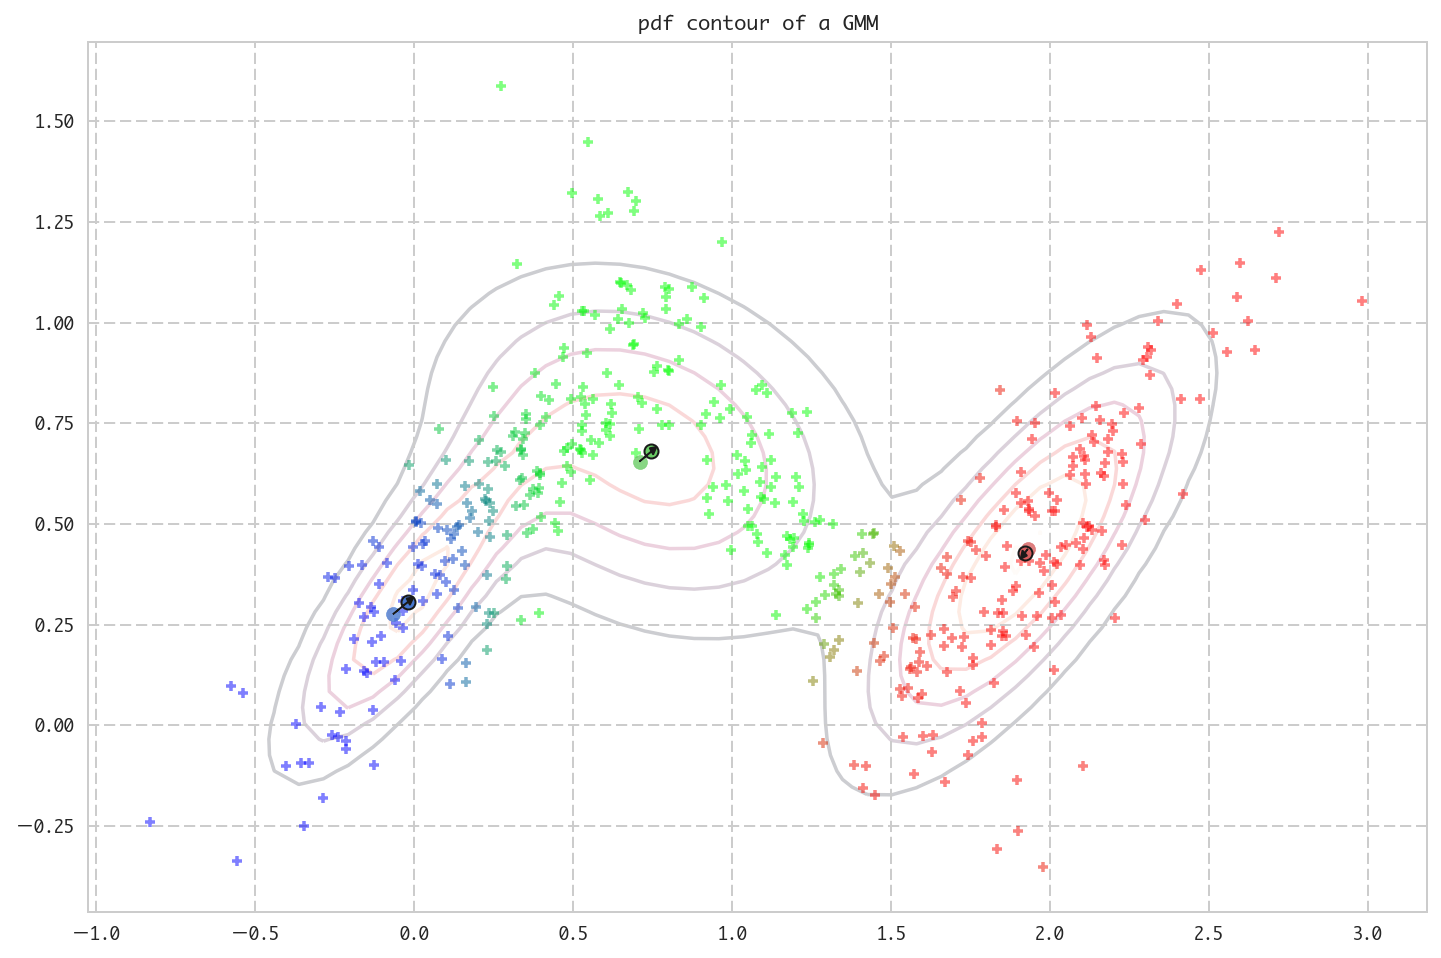

sum of log likelihood: -28328.5588723
diff: -1154.73838277
pi: [ 0.37683523  0.40770899  0.21545578]
mu: [[ 1.9205736   0.42751283]
 [ 0.78902321  0.69400836]
 [ 0.02415123  0.3407583 ]]
sigma: [[[ 0.10113618  0.07615921]
  [ 0.07615921  0.10037138]]

 [[ 0.1497462  -0.03834643]
  [-0.03834643  0.07168103]]

 [[ 0.06267801  0.05047078]
  [ 0.05047078  0.06372459]]]


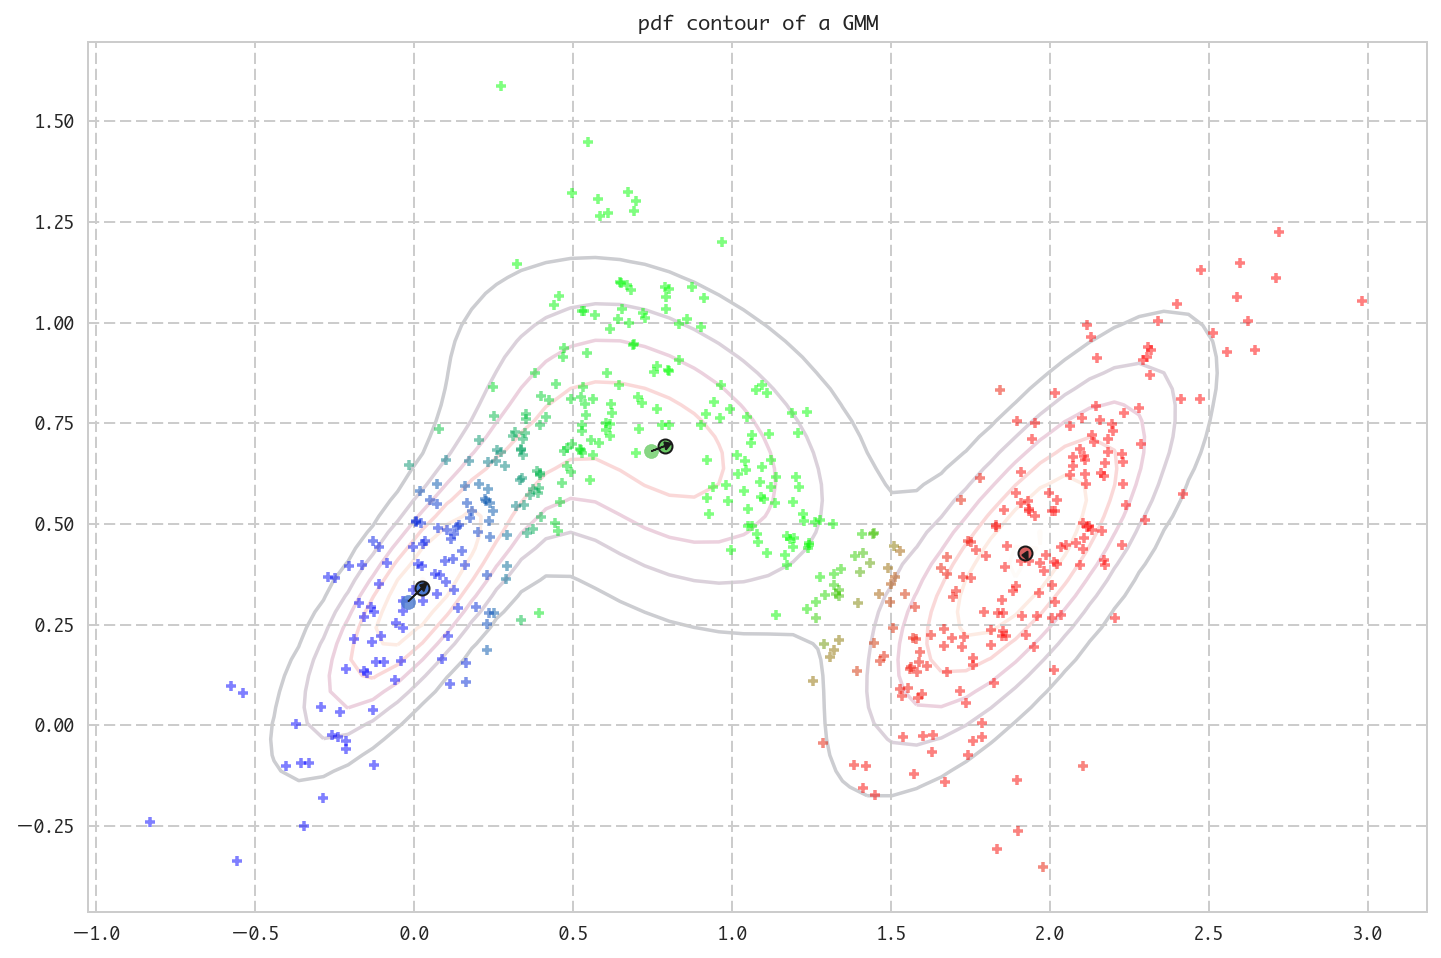

sum of log likelihood: -27773.142485
diff: -555.416387306
pi: [ 0.37325755  0.37672677  0.25001568]
mu: [[ 1.92456398  0.42966063]
 [ 0.84002205  0.69996612]
 [ 0.06326936  0.37359113]]
sigma: [[[ 0.10010315  0.07633931]
  [ 0.07633931  0.10056299]]

 [[ 0.14041077 -0.05237983]
  [-0.05237983  0.07562285]]

 [[ 0.06796566  0.05418063]
  [ 0.05418063  0.06654347]]]


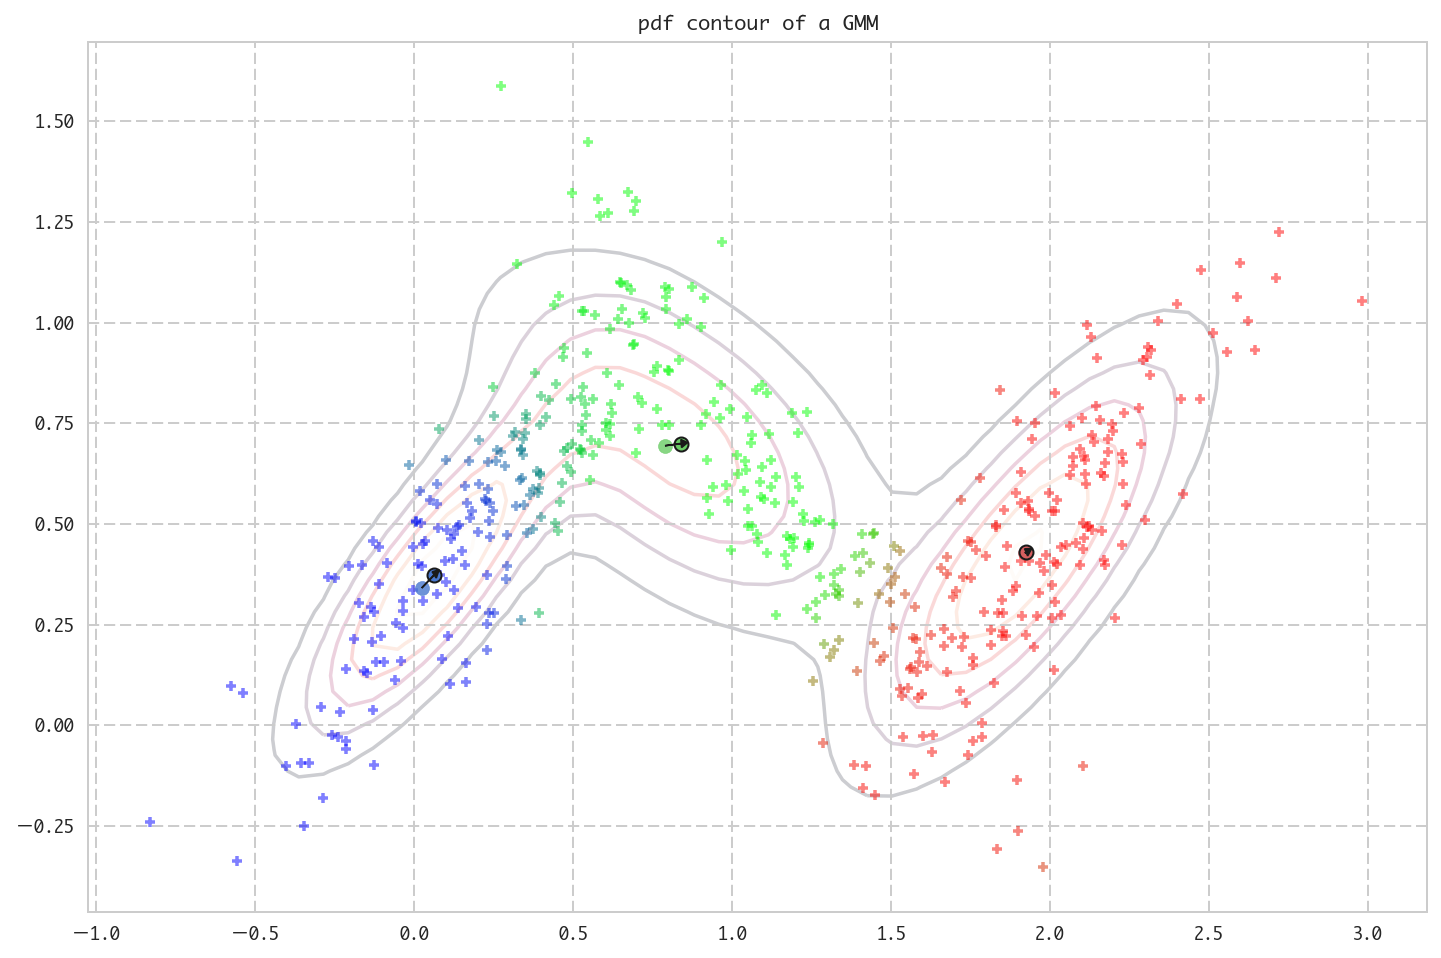

sum of log likelihood: -28159.5626353
diff: 386.420150269
pi: [ 0.36624771  0.34983196  0.28392033]
mu: [[ 1.93198334  0.43479717]
 [ 0.89986928  0.69511979]
 [ 0.0994915   0.40523728]]
sigma: [[[ 0.0982324   0.07656298]
  [ 0.07656298  0.10026591]]

 [[ 0.13347165 -0.06899839]
  [-0.06899839  0.08453397]]

 [[ 0.07329165  0.05827625]
  [ 0.05827625  0.06990516]]]


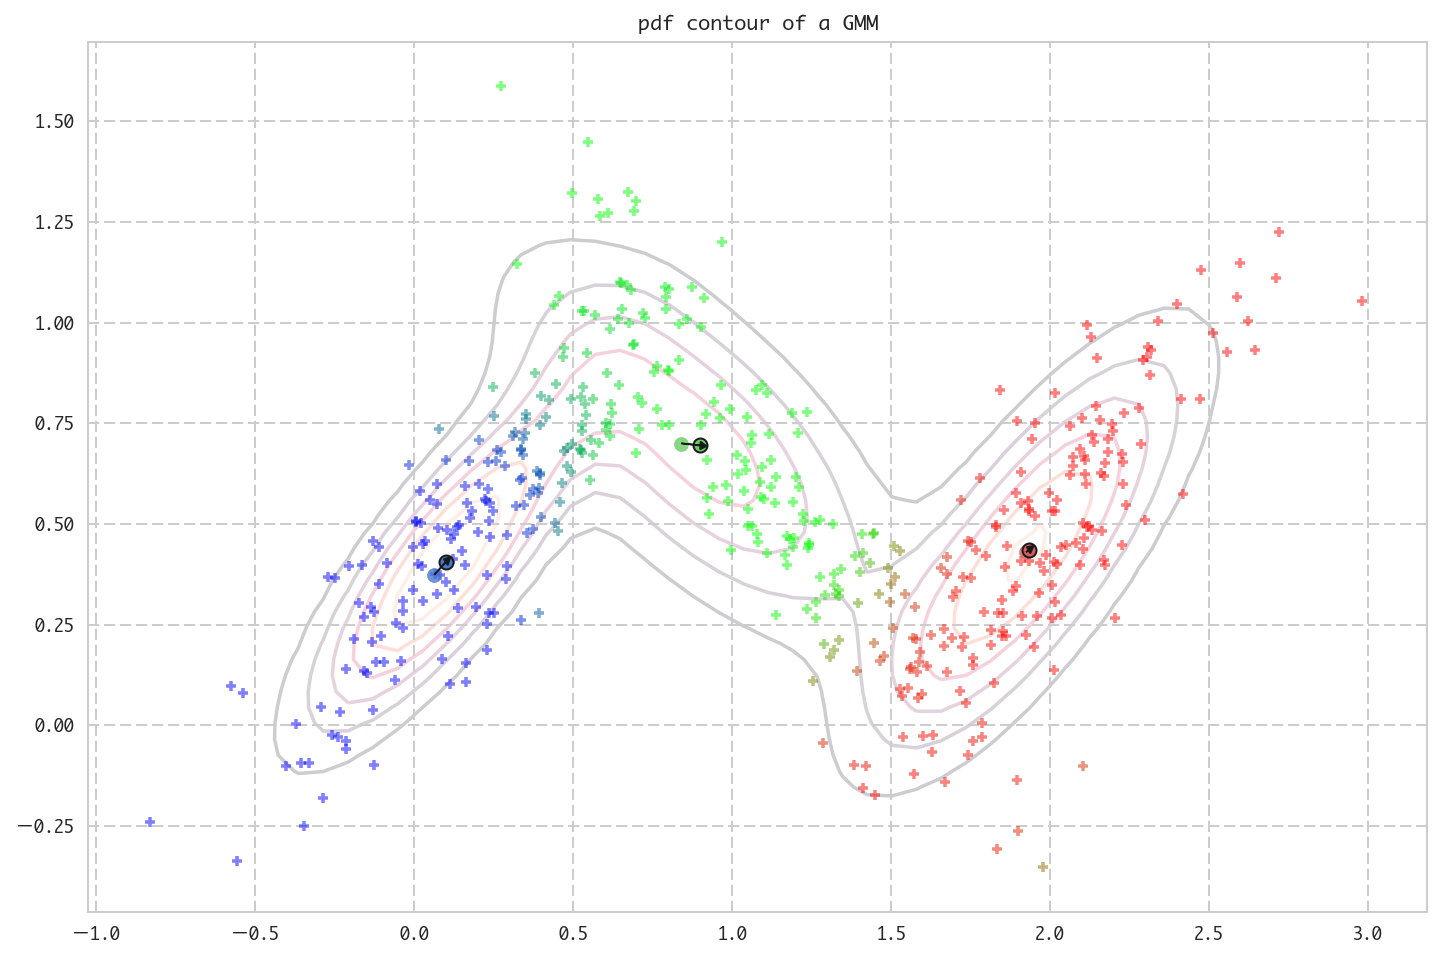

sum of log likelihood: -29897.5008964
diff: 1737.9382611
pi: [ 0.35495075  0.32959286  0.3154564 ]
mu: [[ 1.94304675  0.44509806]
 [ 0.96819782  0.67447347]
 [ 0.13262748  0.43487519]]
sigma: [[[ 0.09577164  0.07674131]
  [ 0.07674131  0.09839827]]

 [[ 0.13093051 -0.08831076]
  [-0.08831076  0.09995558]]

 [[ 0.07880949  0.06289473]
  [ 0.06289473  0.0737204 ]]]


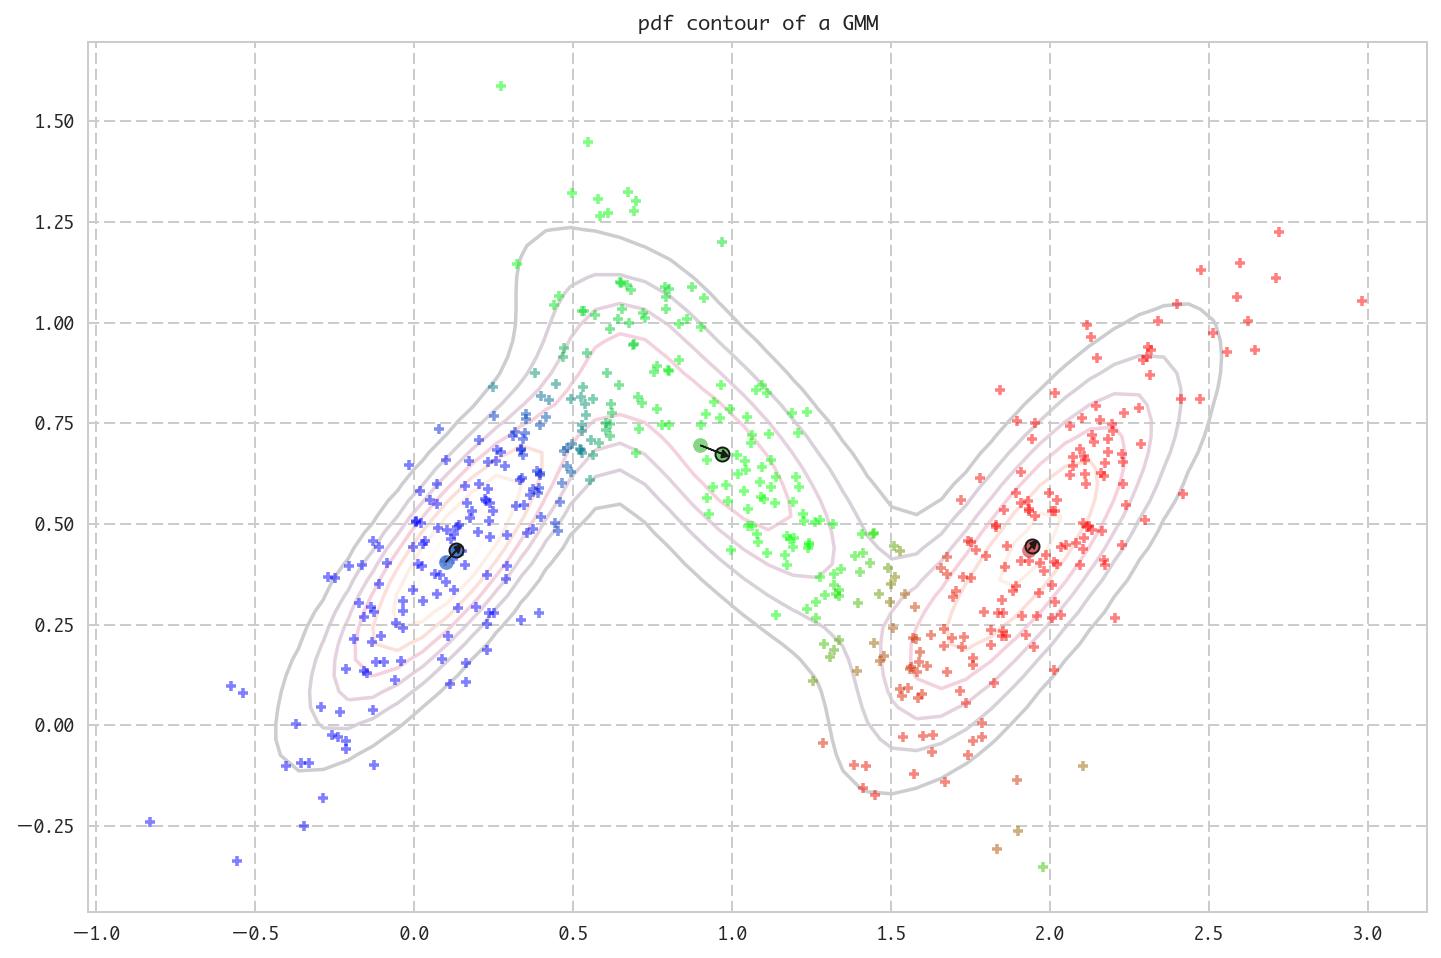

sum of log likelihood: -32922.736861
diff: 3025.2359646
pi: [ 0.34008173  0.31732922  0.34258905]
mu: [[ 1.95756968  0.46113718]
 [ 1.03802865  0.63859623]
 [ 0.1620153   0.46120597]]
sigma: [[[ 0.09296249  0.07623417]
  [ 0.07623417  0.09458259]]

 [[ 0.13190283 -0.10650929]
  [-0.10650929  0.11846631]]

 [[ 0.084664    0.0680261 ]
  [ 0.0680261   0.07789015]]]


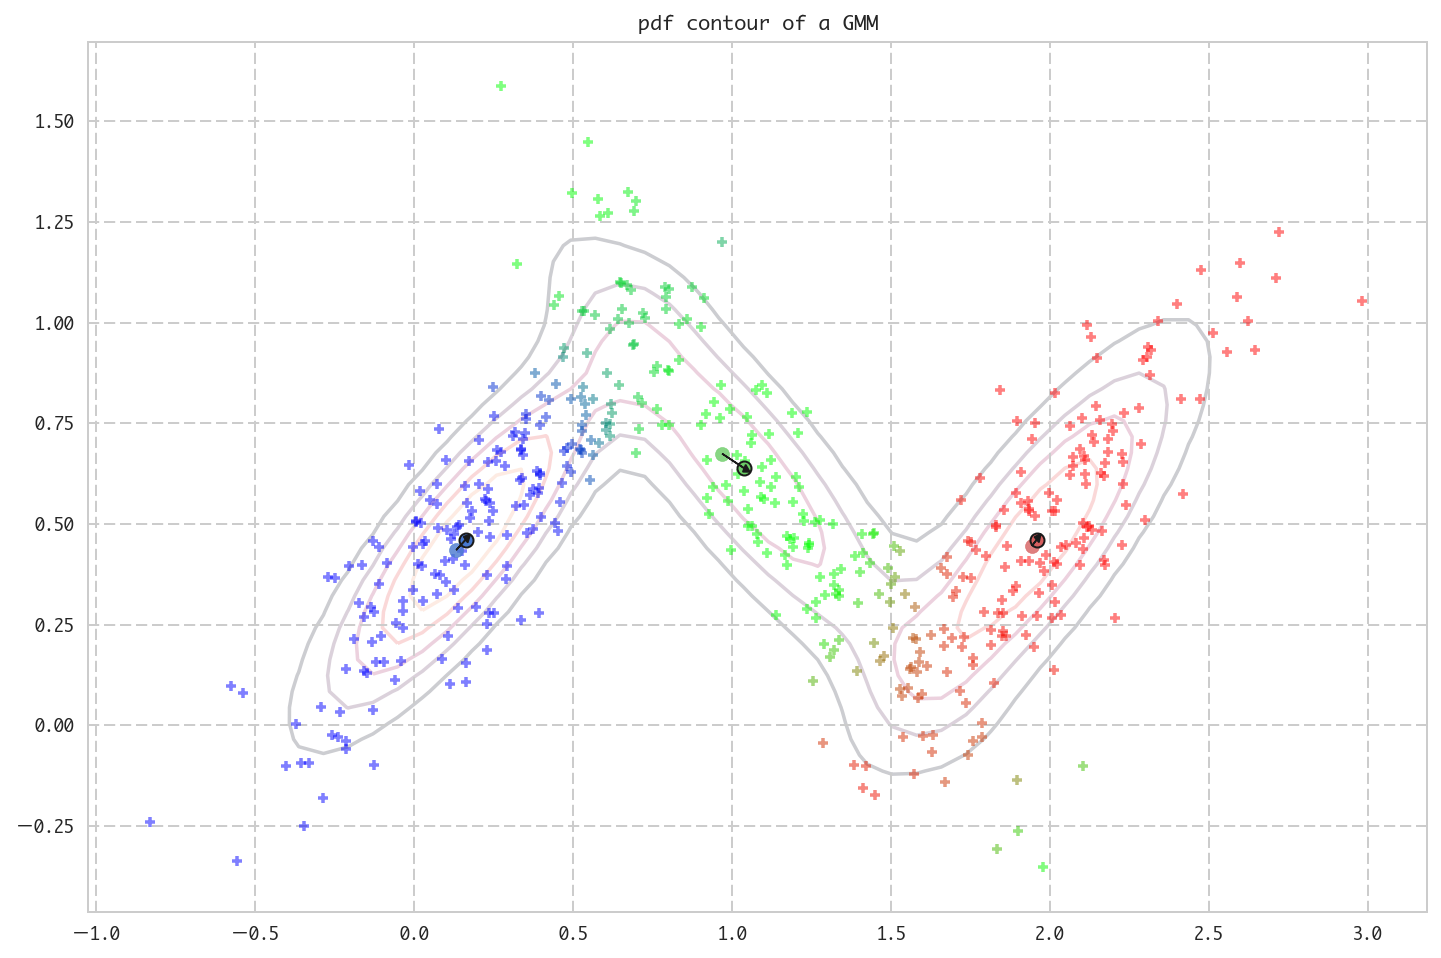

sum of log likelihood: -35819.421178
diff: 2896.68431704
pi: [ 0.32661014  0.3098558   0.36353406]
mu: [[ 1.9722275   0.47691207]
 [ 1.09394608  0.60160737]
 [ 0.18573263  0.48220472]]
sigma: [[[ 0.09012167  0.0746721 ]
  [ 0.0746721   0.09088945]]

 [[ 0.13107904 -0.11684259]
  [-0.11684259  0.13106124]]

 [[ 0.09023122  0.07291715]
  [ 0.07291715  0.08192911]]]


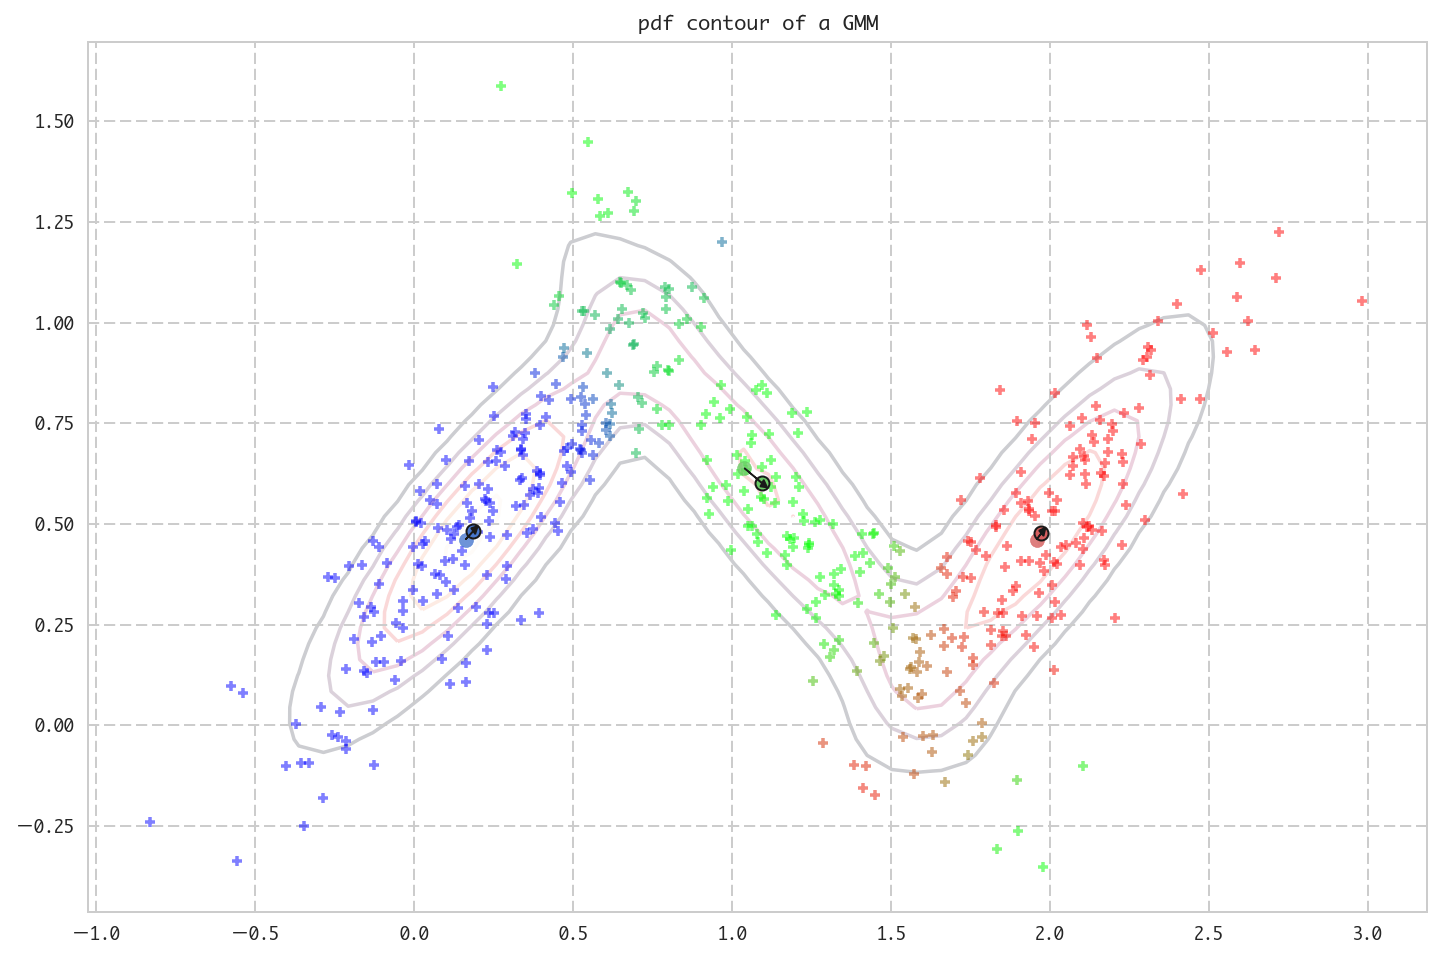

sum of log likelihood: -37536.4491283
diff: 1717.02795026
pi: [ 0.31821465  0.30436758  0.37741777]
mu: [[ 1.98235975  0.48732921]
 [ 1.12905013  0.57487599]
 [ 0.20182672  0.49659766]]
sigma: [[[ 0.08806338  0.07305036]
  [ 0.07305036  0.08850773]]

 [[ 0.12846871 -0.12013846]
  [-0.12013846  0.13634425]]

 [[ 0.09436749  0.07657764]
  [ 0.07657764  0.08516457]]]


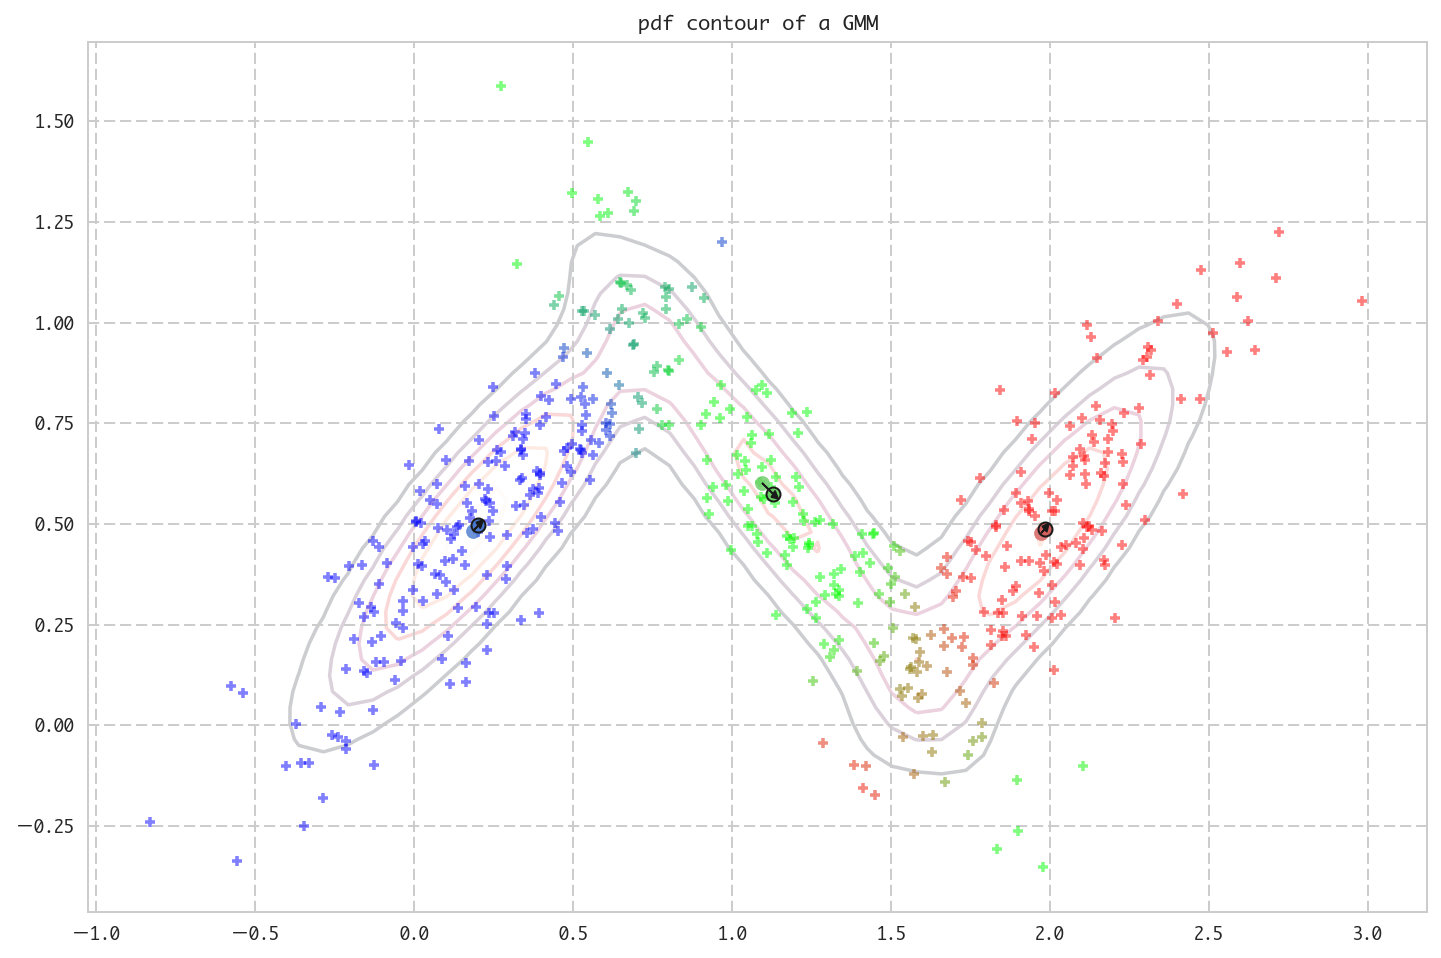

sum of log likelihood: -38303.5982142
diff: 767.149085913
pi: [ 0.314083    0.3002837   0.38563329]
mu: [[ 1.98761755  0.49273754]
 [ 1.14843856  0.55880808]
 [ 0.211343    0.50543417]]
sigma: [[[ 0.08696769  0.07203395]
  [ 0.07203395  0.08721879]]

 [[ 0.12602341 -0.12045025]
  [-0.12045025  0.13786173]]

 [[ 0.09687629  0.07887041]
  [ 0.07887041  0.08741386]]]


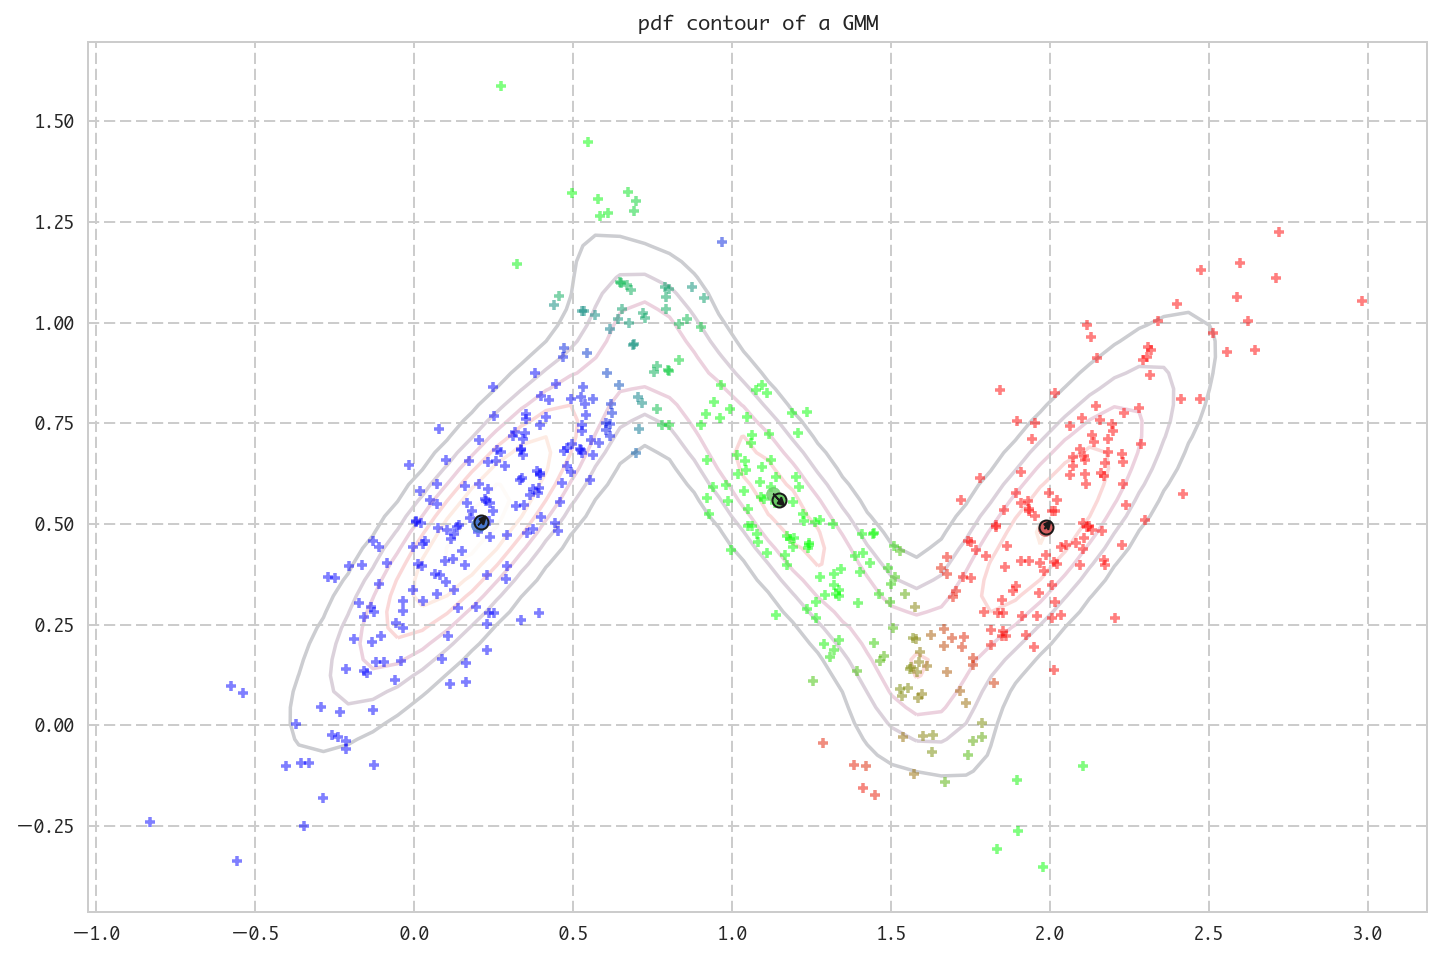

sum of log likelihood: -38608.8793898
diff: 305.281175615
pi: [ 0.31224492  0.29750661  0.39024847]
mu: [[ 1.99001321  0.49524623]
 [ 1.15872183  0.54983794]
 [ 0.21662163  0.51058533]]
sigma: [[[ 0.08646158  0.07151416]
  [ 0.07151416  0.08658636]]

 [[ 0.12429283 -0.11996964]
  [-0.11996964  0.13802363]]

 [[ 0.09825598  0.08020605]
  [ 0.08020605  0.0888636 ]]]


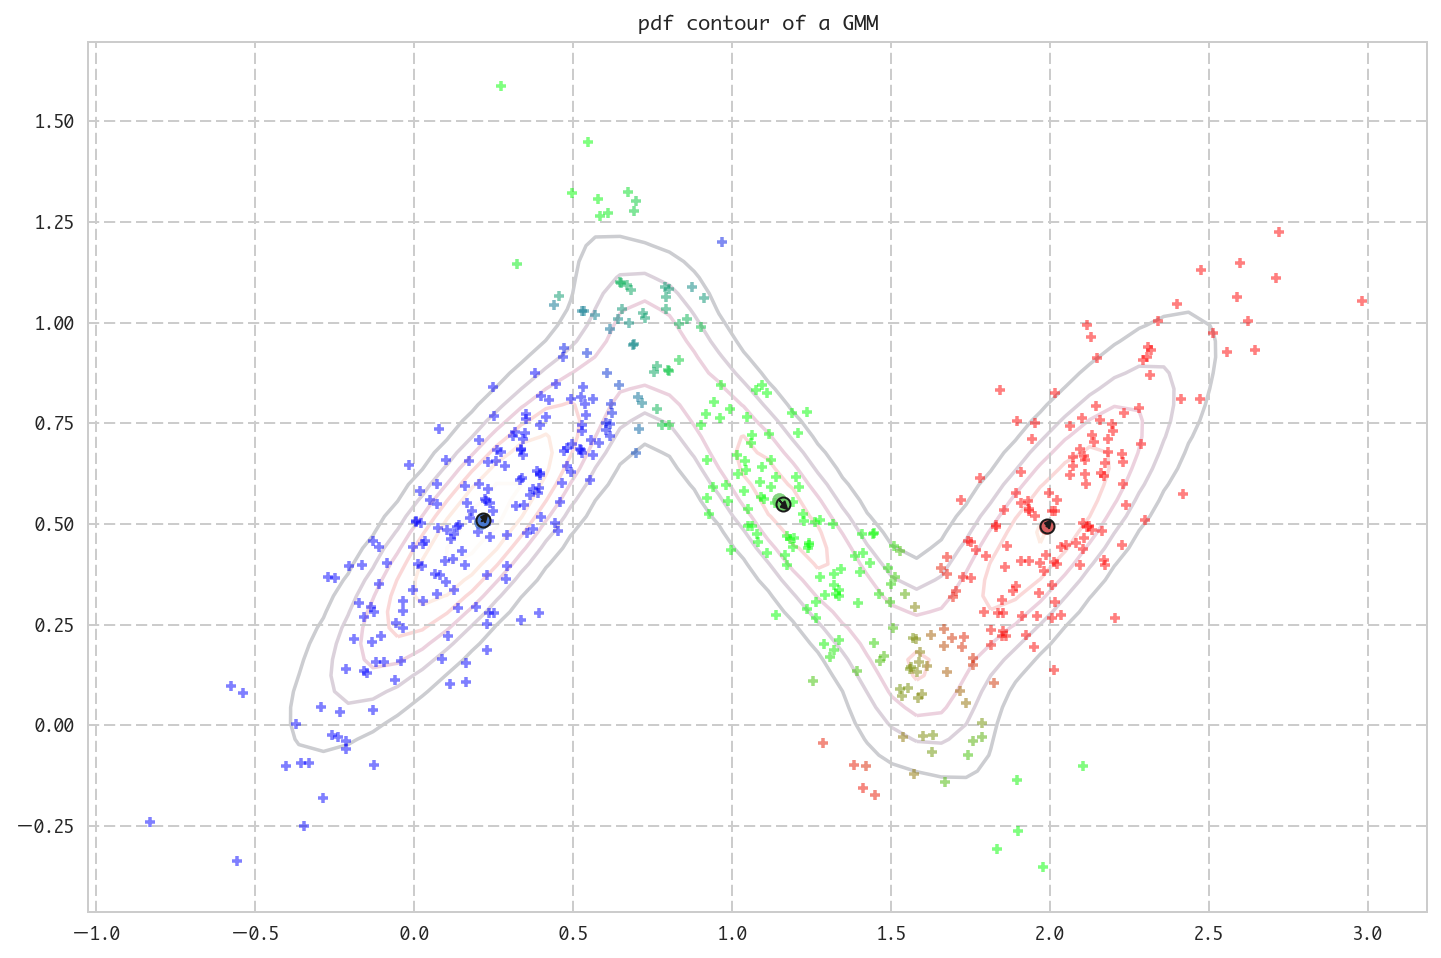

sum of log likelihood: -38731.0599157
diff: 122.180525891
pi: [ 0.31144479  0.29575924  0.39279597]
mu: [[ 1.99107052  0.49637407]
 [ 1.16415239  0.54494054]
 [ 0.2194977   0.513522  ]]
sigma: [[[ 0.08623507  0.07126498]
  [ 0.07126498  0.08628699]]

 [[ 0.12320082 -0.11945412]
  [-0.11945412  0.13783193]]

 [[ 0.09899494  0.08096752]
  [ 0.08096752  0.08975593]]]


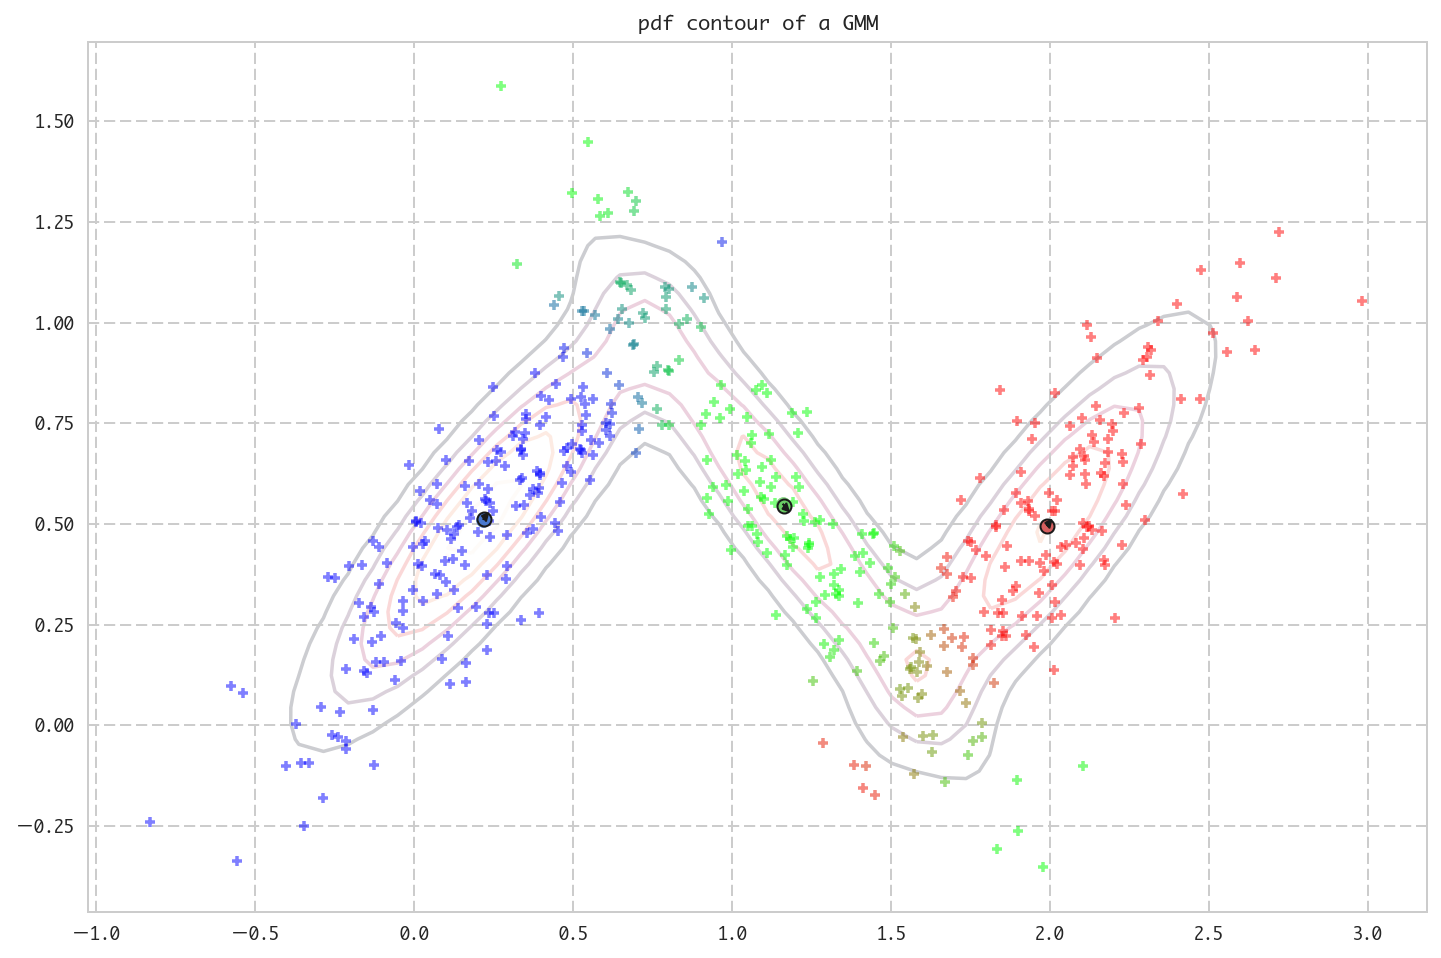

sum of log likelihood: -38783.1052916
diff: 52.0453759208
pi: [ 0.31109187  0.29471013  0.394198  ]
mu: [[ 1.99154209  0.49688428]
 [ 1.1670412   0.54227555]
 [ 0.22106594  0.51518001]]
sigma: [[[ 0.08613253  0.07114692]
  [ 0.07114692  0.08614598]]

 [[ 0.12255021 -0.11907733]
  [-0.11907733  0.13761418]]

 [[ 0.09939214  0.08139901]
  [ 0.08139901  0.09028848]]]


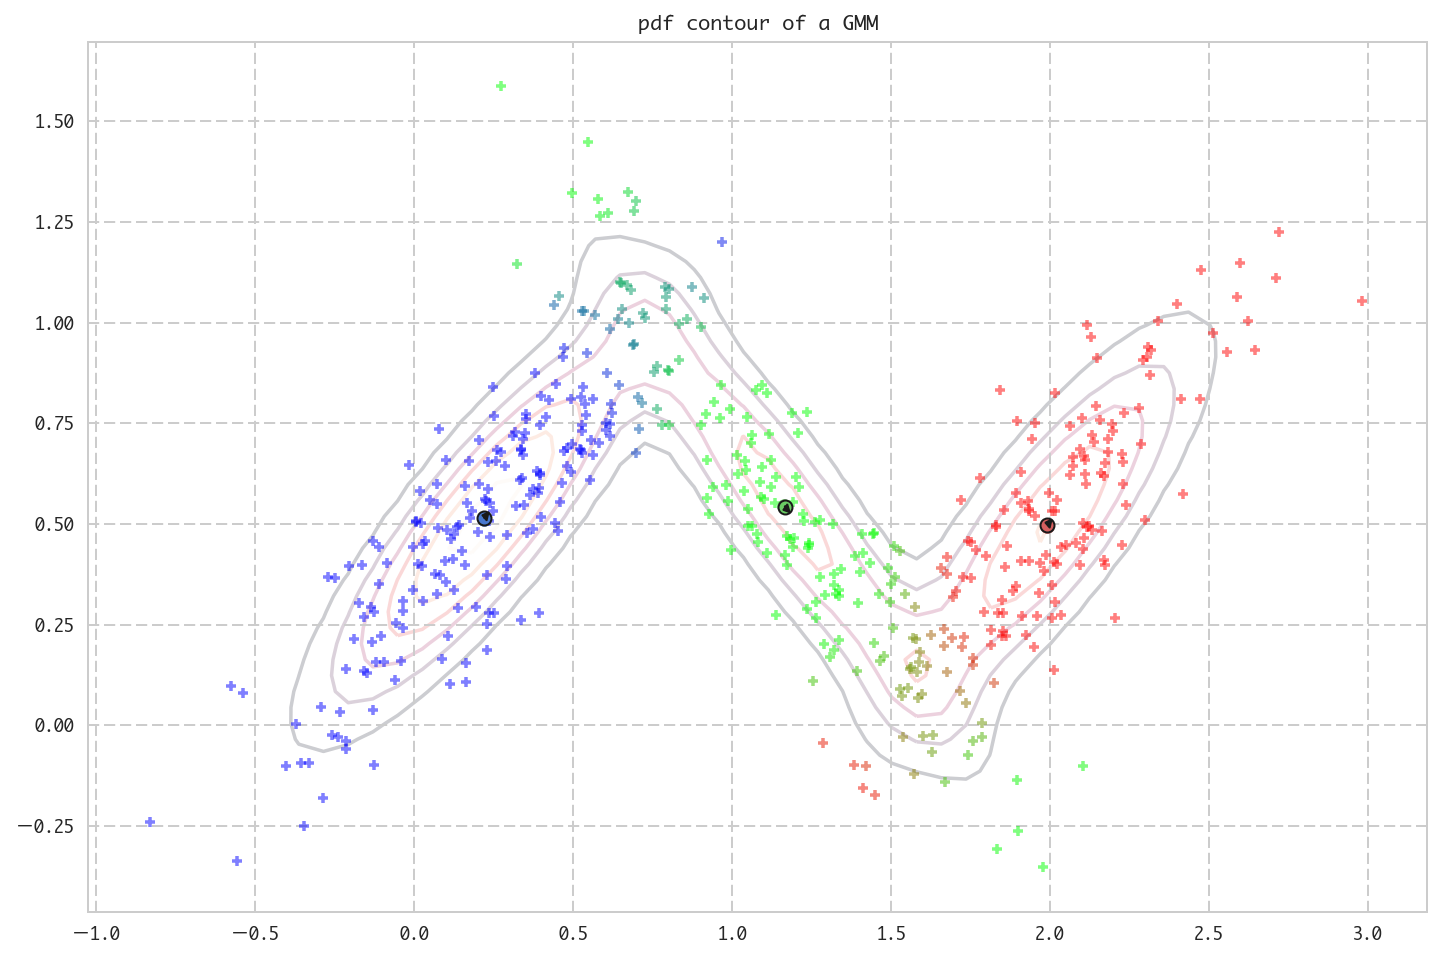

sum of log likelihood: -38806.9677649
diff: 23.8624732872
pi: [ 0.31093227  0.29409663  0.3949711 ]
mu: [[ 1.99175742  0.49711965]
 [ 1.16859287  0.54082179]
 [ 0.22192583  0.51611189]]
sigma: [[[ 0.08608519  0.07109064]
  [ 0.07109064  0.08607906]]

 [[ 0.12217411 -0.1188353 ]
  [-0.1188353   0.13744974]]

 [[ 0.09960793  0.08164285]
  [ 0.08164285  0.09059967]]]


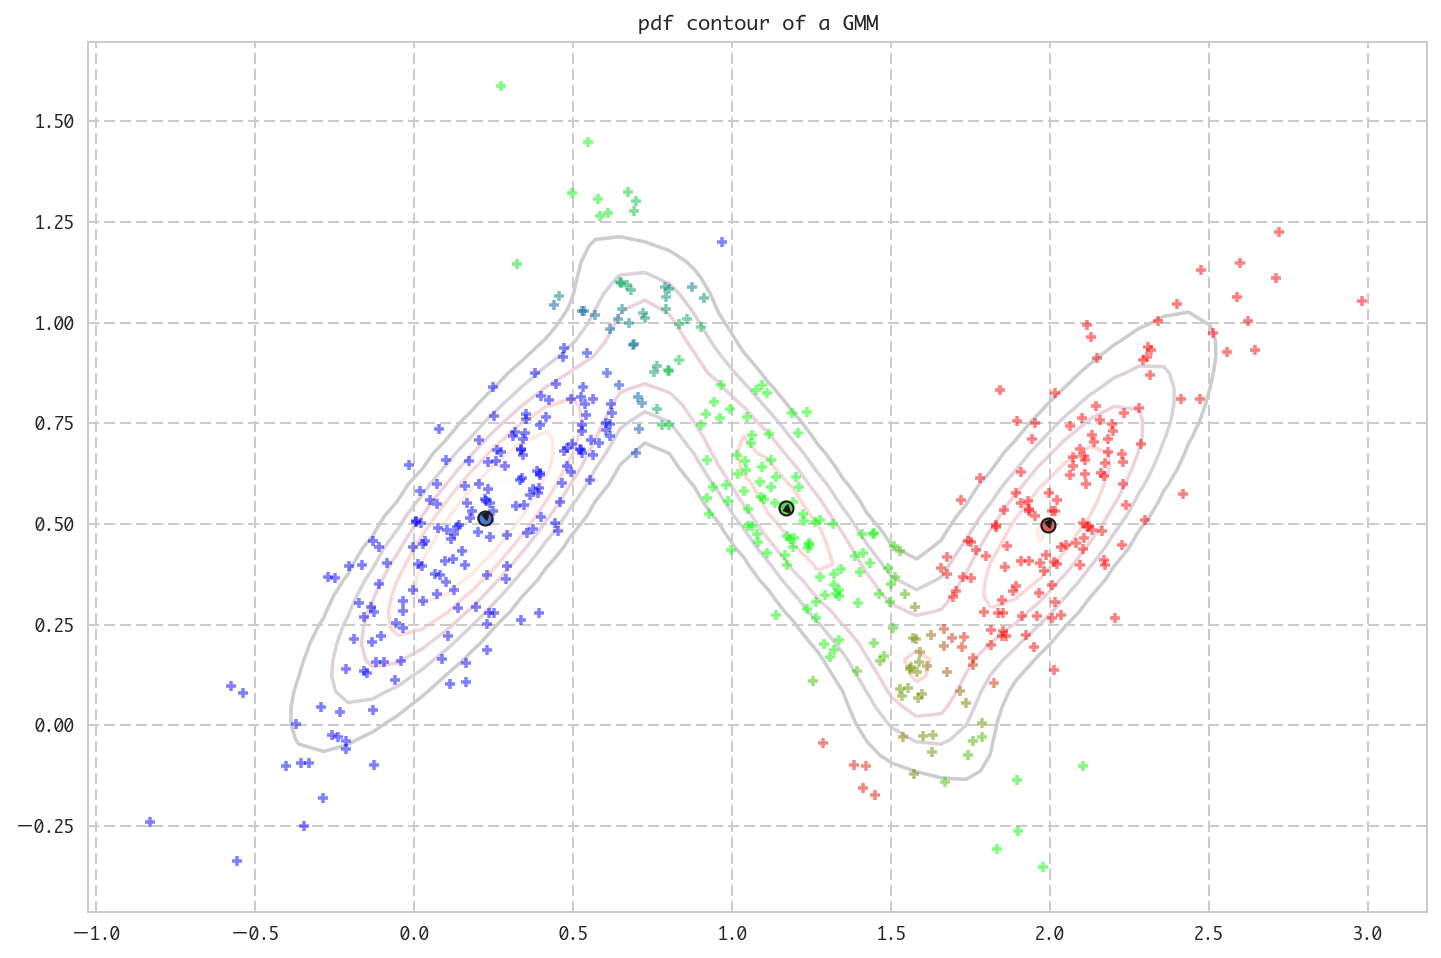

sum of log likelihood: -38818.6109914
diff: 11.6432264411
pi: [ 0.31085815  0.29374324  0.39539862]
mu: [[ 1.99185823  0.49723074]
 [ 1.16943364  0.5400259 ]
 [ 0.22239985  0.51663435]]
sigma: [[[ 0.08606294  0.0710635 ]
  [ 0.0710635   0.08604687]]

 [[ 0.1219602  -0.11868888]
  [-0.11868888  0.13734141]]

 [[ 0.09972628  0.08178034]
  [ 0.08178034  0.09077888]]]


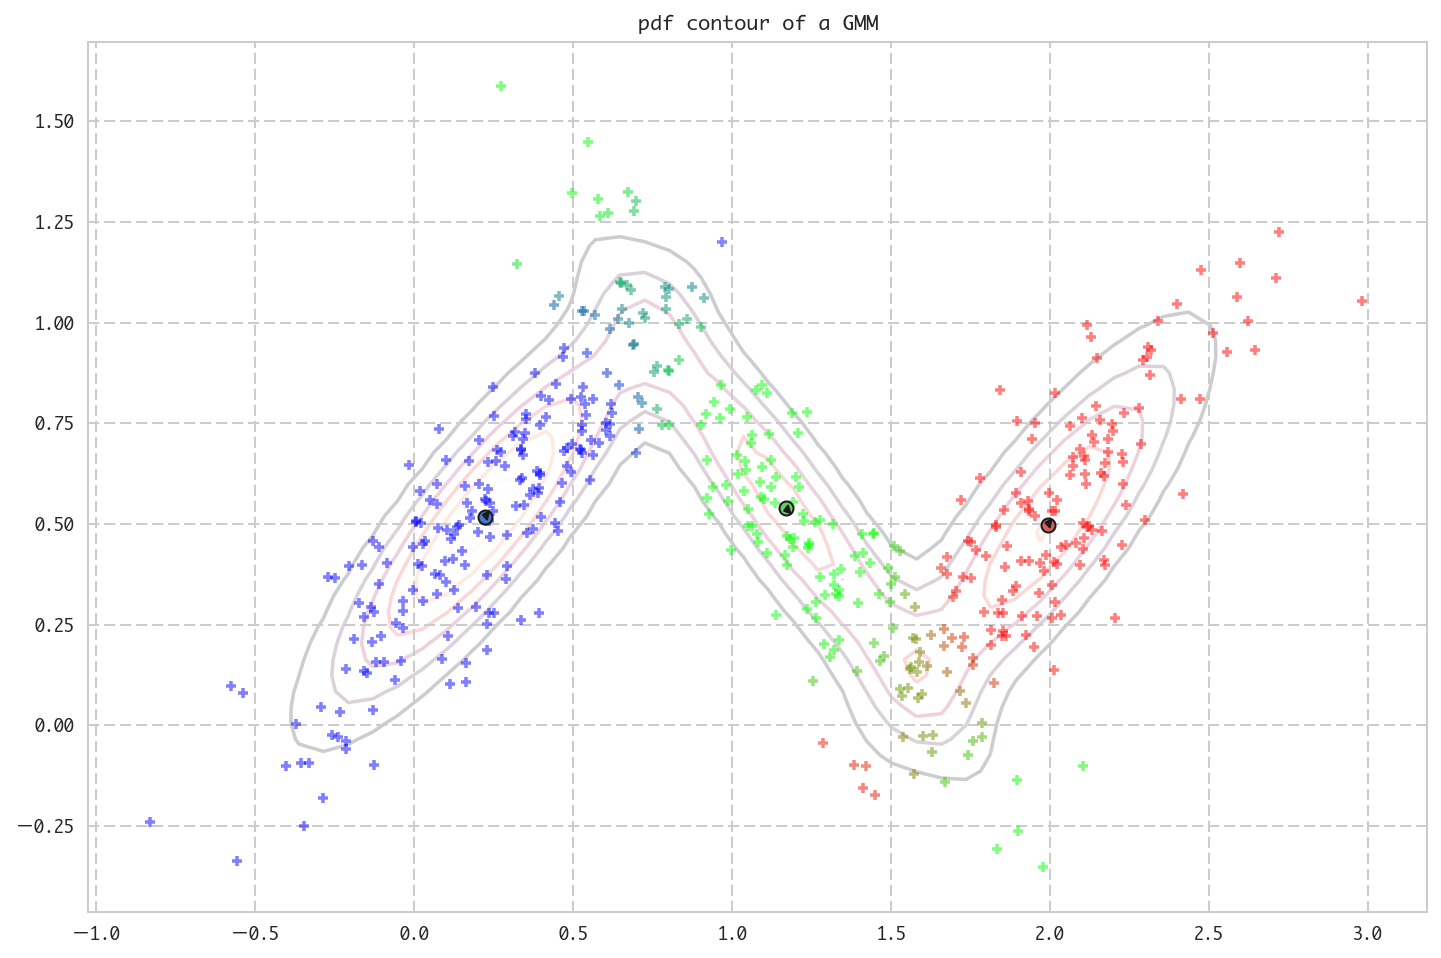

sum of log likelihood: -38824.5525148
diff: 5.94152346828
pi: [ 0.31082286  0.29354154  0.3956356 ]
mu: [[ 1.9919065   0.49728436]
 [ 1.16989237  0.53958872]
 [ 0.2226622   0.51692678]]
sigma: [[[ 0.08605232  0.07105021]
  [ 0.07105021  0.08603112]]

 [[ 0.1218396  -0.11860309]
  [-0.11860309  0.1372746 ]]

 [[ 0.09979163  0.08185769]
  [ 0.08185769  0.09088104]]]


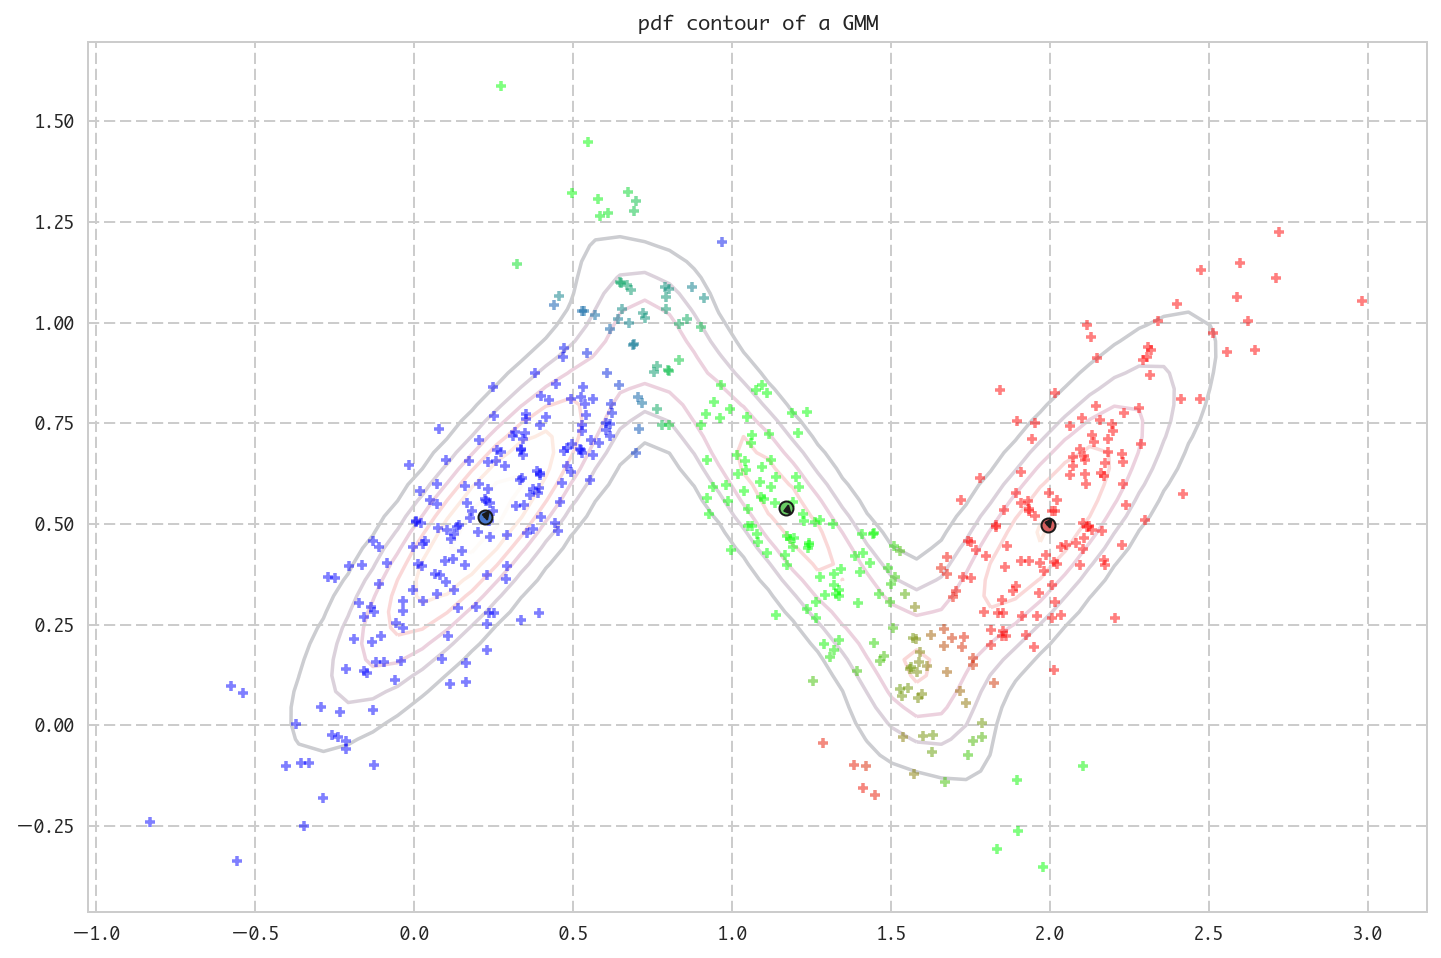

sum of log likelihood: -38827.6758358
diff: 3.12332098263
pi: [ 0.3108057  0.2934271  0.3957672]
mu: [[ 1.99193006  0.49731078]
 [ 1.17014395  0.53934794]
 [ 0.22280778  0.51709025]]
sigma: [[[ 0.08604719  0.07104361]
  [ 0.07104361  0.08602328]]

 [[ 0.12177194 -0.11855375]
  [-0.11855375  0.13723488]]

 [[ 0.09982785  0.0819011 ]
  [ 0.0819011   0.09093884]]]


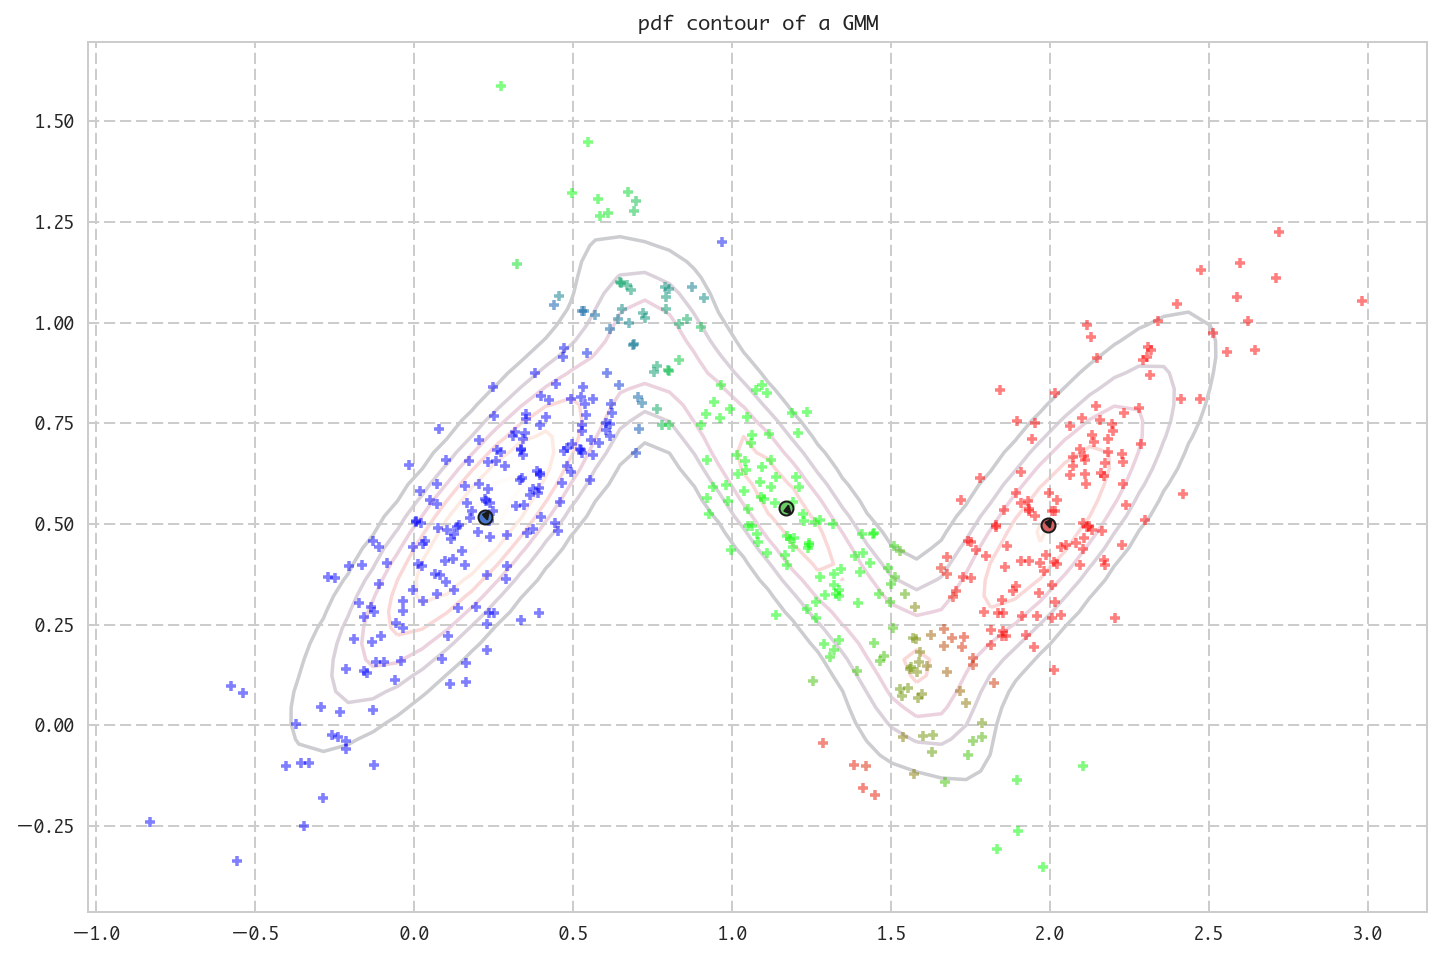

sum of log likelihood: -38829.3491254
diff: 1.67328962615
pi: [ 0.3107972   0.29336244  0.39584036]
mu: [[ 1.99194176  0.49732404]
 [ 1.17028243  0.53921505]
 [ 0.22288869  0.51718154]]
sigma: [[[ 0.08604469  0.07104028]
  [ 0.07104028  0.0860193 ]]

 [[ 0.12173407 -0.11852568]
  [-0.11852568  0.1372118 ]]

 [[ 0.09984798  0.08192542]
  [ 0.08192542  0.09097139]]]


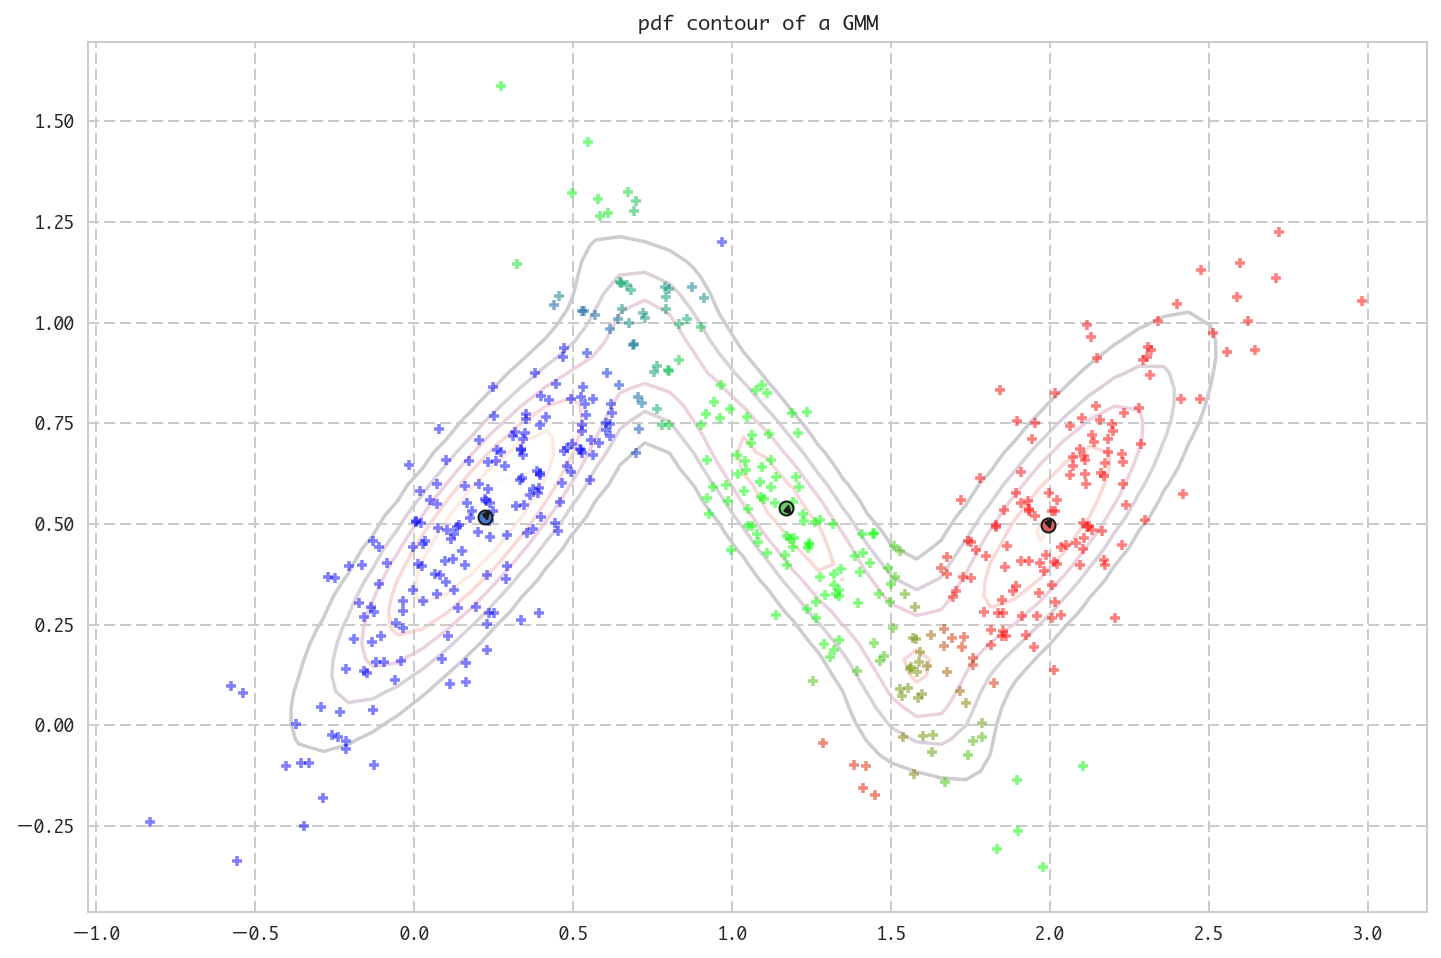

sum of log likelihood: -38830.2564252
diff: 0.907299738174
pi: [ 0.31079293  0.29332601  0.39588106]
mu: [[ 1.99194764  0.4973308 ]
 [ 1.17035886  0.53914159]
 [ 0.2229337   0.51723248]]
sigma: [[[ 0.08604345  0.07103858]
  [ 0.07103858  0.08601725]]

 [[ 0.12171291 -0.11850983]
  [-0.11850983  0.13719858]]

 [[ 0.09985918  0.08193902]
  [ 0.08193902  0.09098966]]]


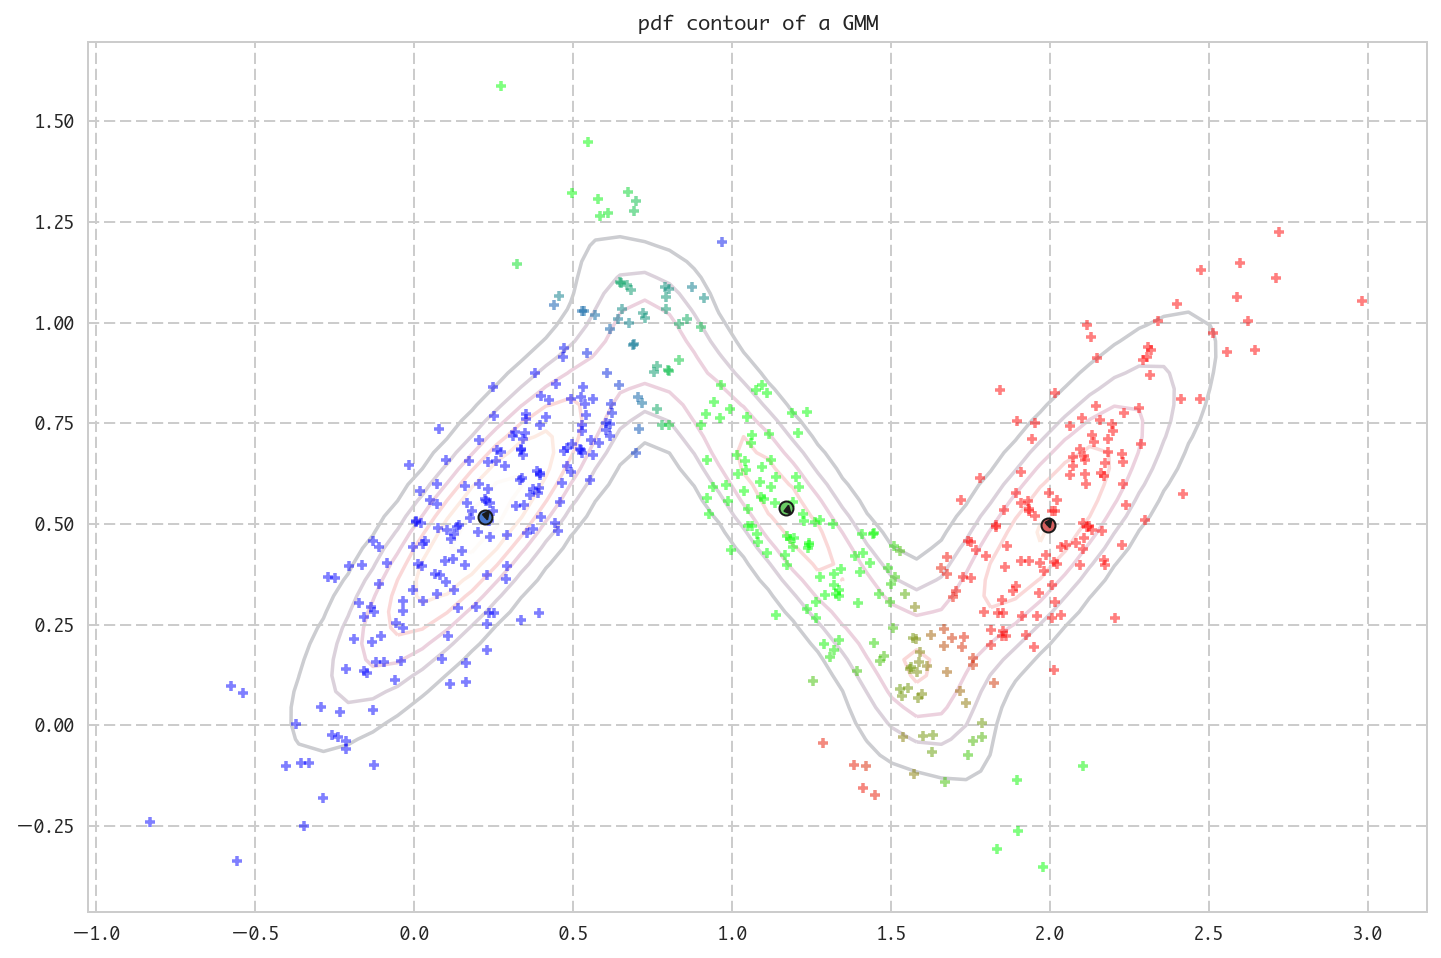

sum of log likelihood: -38830.7521956
diff: 0.495770391281
pi: [ 0.31079076  0.29330553  0.39590371]
mu: [[ 1.99195064  0.49733428]
 [ 1.17040111  0.53910093]
 [ 0.22295875  0.51726089]]
sigma: [[[ 0.08604284  0.07103769]
  [ 0.07103769  0.08601618]]

 [[ 0.1217011  -0.11850091]
  [-0.11850091  0.13719107]]

 [[ 0.09986542  0.08194662]
  [ 0.08194662  0.09099987]]]


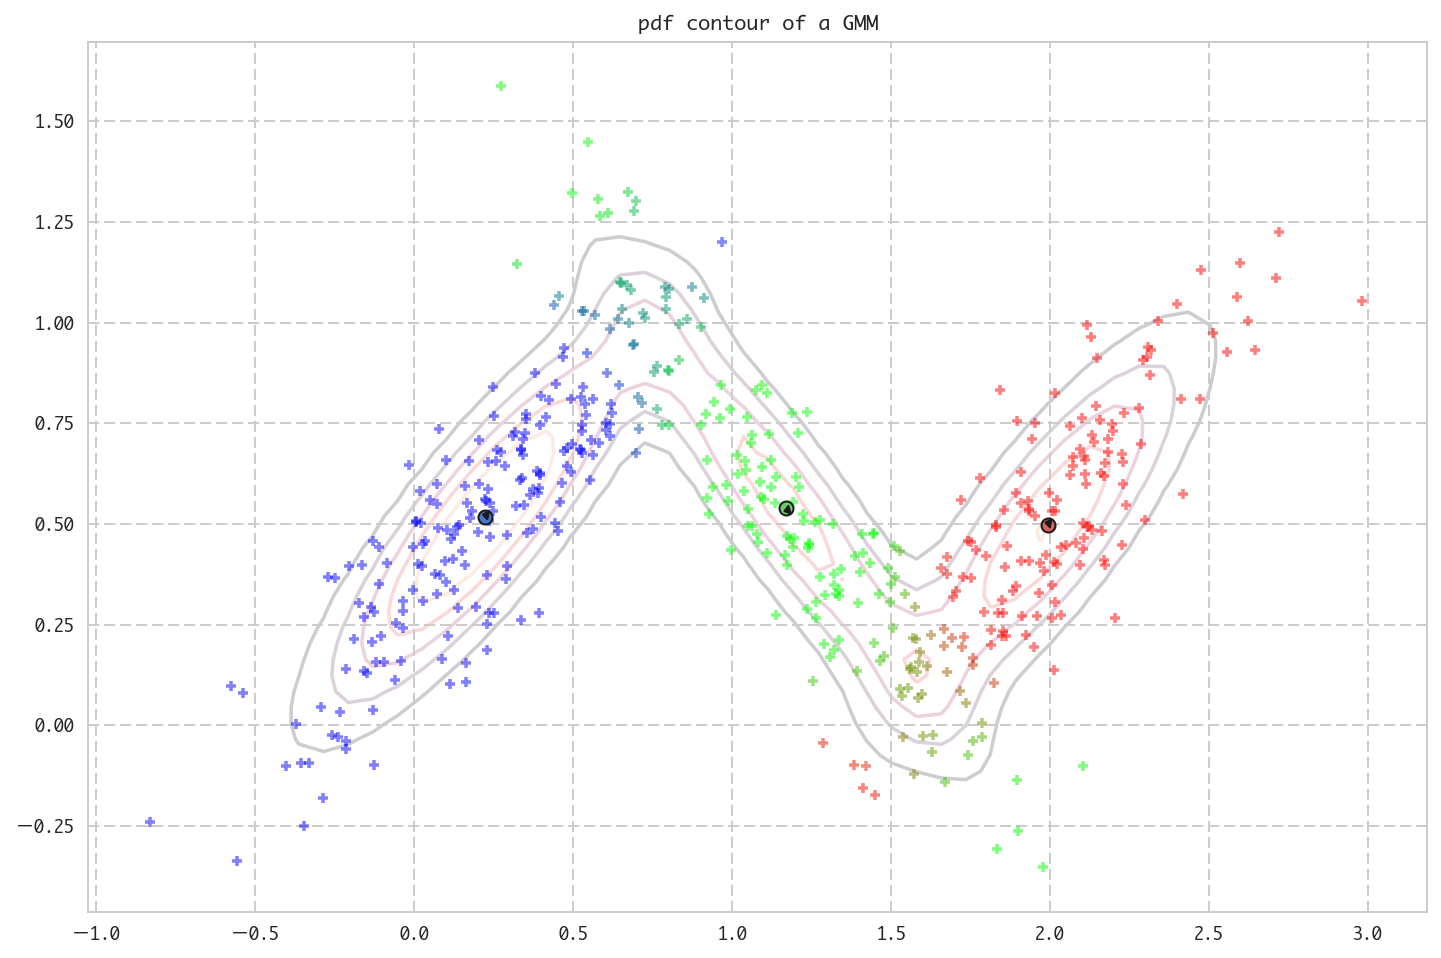

sum of log likelihood: -38831.0244659
diff: 0.272270341906
pi: [ 0.31078965  0.29329403  0.39591632]
mu: [[ 1.99195218  0.4973361 ]
 [ 1.17042451  0.53907841]
 [ 0.2229727   0.51727672]]
sigma: [[[ 0.08604253  0.07103723]
  [ 0.07103723  0.08601562]]

 [[ 0.1216945  -0.11849592]
  [-0.11849592  0.13718683]]

 [[ 0.09986889  0.08195086]
  [ 0.08195086  0.09100558]]]


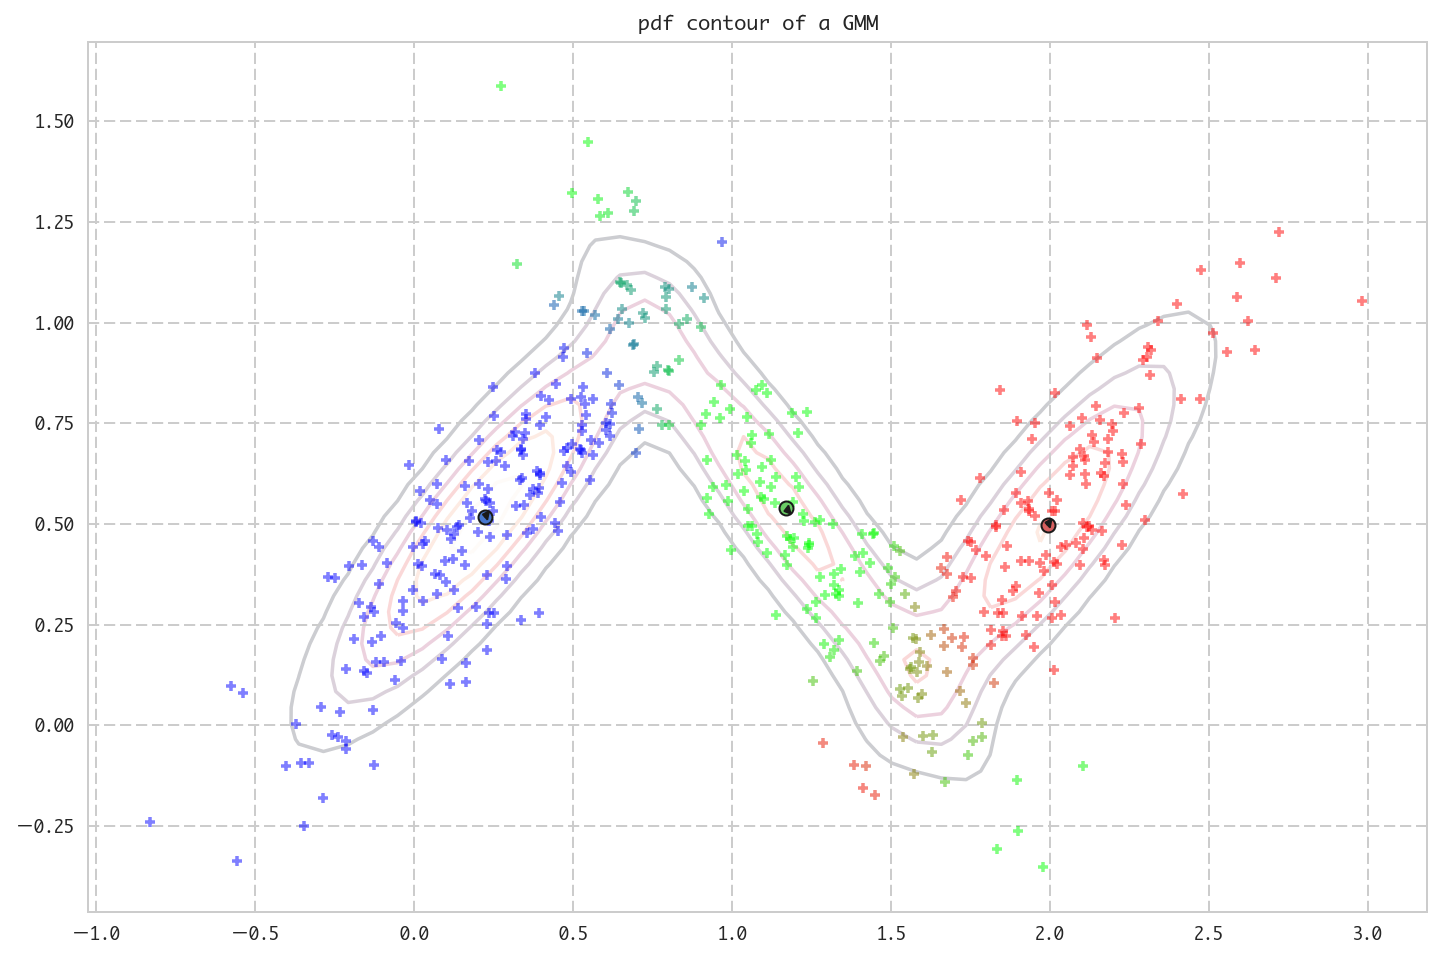

sum of log likelihood: -38831.1744984
diff: 0.150032500016
pi: [ 0.31078907  0.29328759  0.39592334]
mu: [[ 1.99195298  0.49733706]
 [ 1.17043748  0.53906592]
 [ 0.22298046  0.51728555]]
sigma: [[[ 0.08604237  0.07103698]
  [ 0.07103698  0.08601531]]

 [[ 0.12169083 -0.11849312]
  [-0.11849312  0.13718445]]

 [[ 0.09987082  0.08195322]
  [ 0.08195322  0.09100877]]]


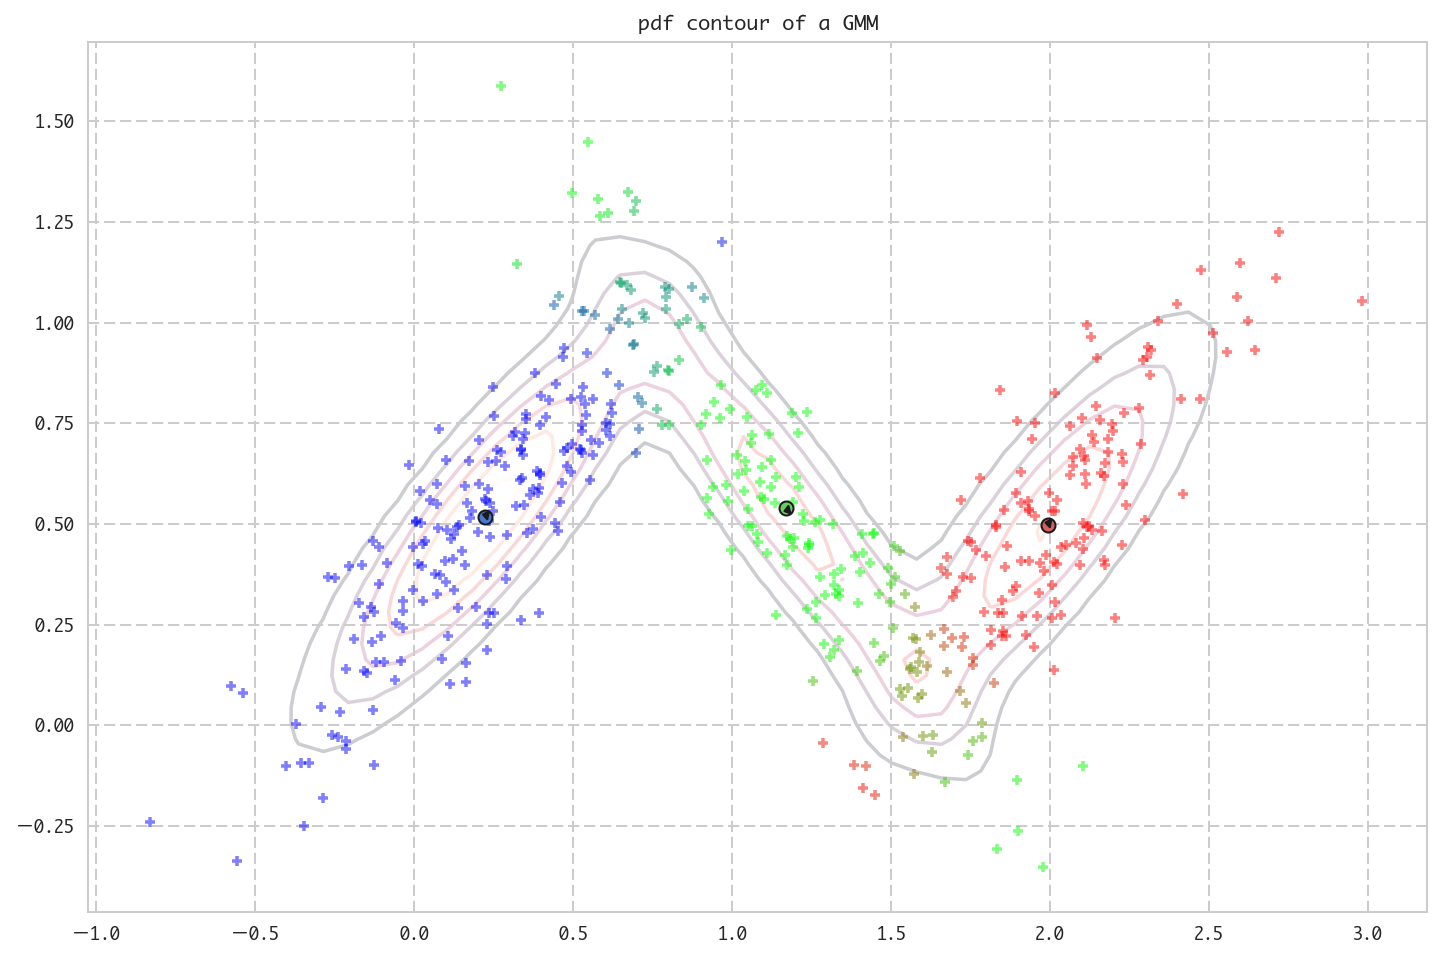

sum of log likelihood: -38831.2573642
diff: 0.0828657783131
pi: [ 0.31078877  0.29328398  0.39592725]
mu: [[ 1.99195339  0.49733757]
 [ 1.17044467  0.53905899]
 [ 0.22298478  0.51729046]]
sigma: [[[ 0.08604229  0.07103685]
  [ 0.07103685  0.08601515]]

 [[ 0.12168877 -0.11849156]
  [-0.11849156  0.13718312]]

 [[ 0.0998719   0.08195454]
  [ 0.08195454  0.09101055]]]


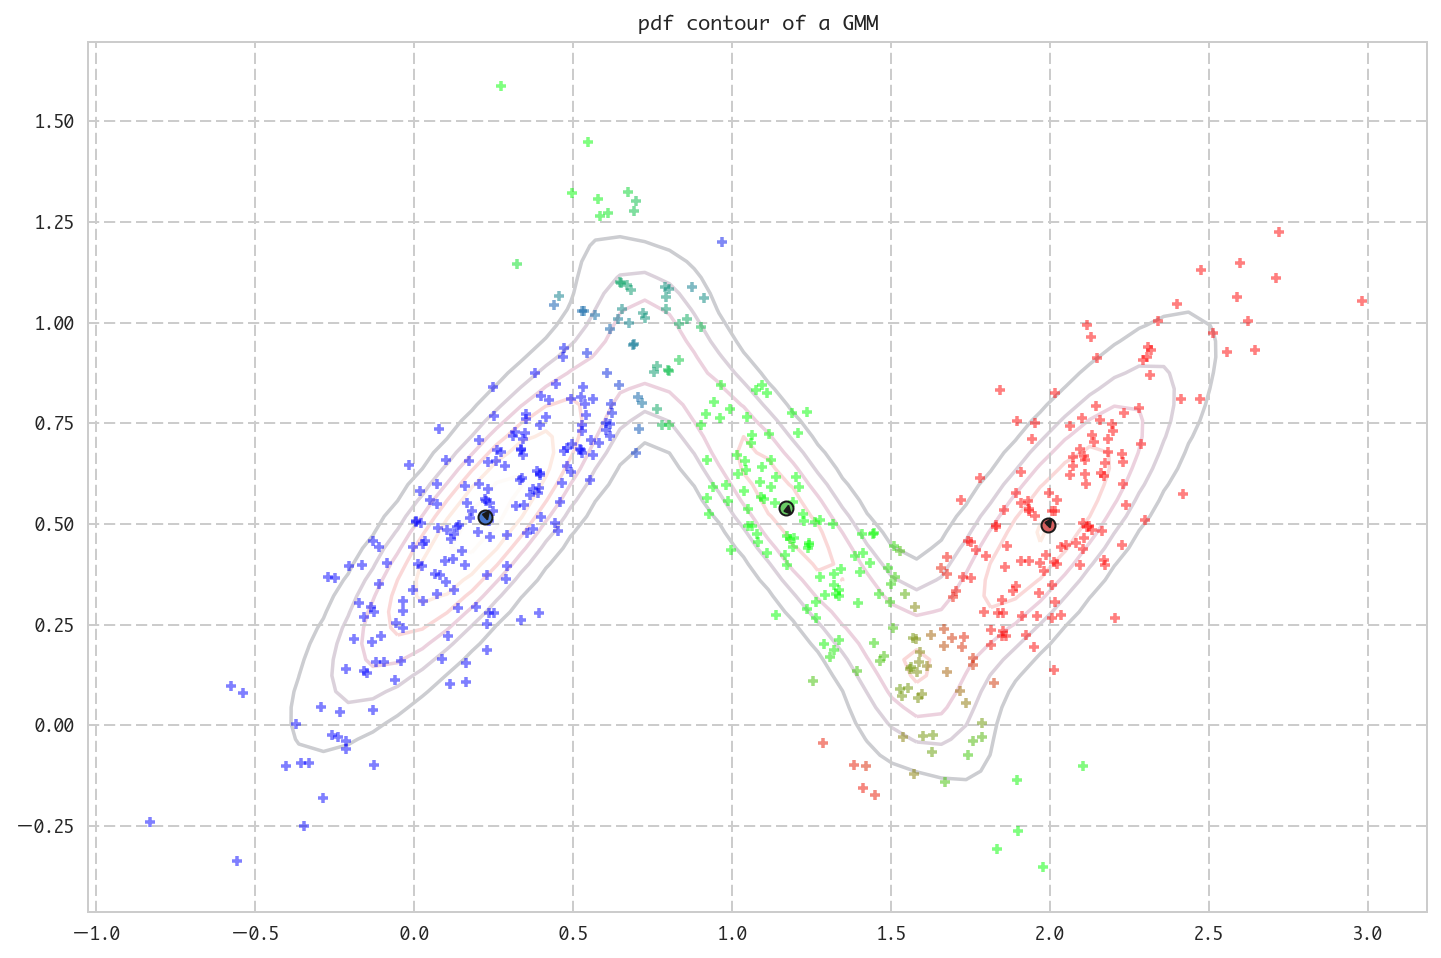

sum of log likelihood: -38831.303207
diff: 0.0458428561542
pi: [ 0.31078861  0.29328196  0.39592942]
mu: [[ 1.99195361  0.49733784]
 [ 1.17044866  0.53905515]
 [ 0.22298719  0.5172932 ]]
sigma: [[[ 0.08604225  0.07103678]
  [ 0.07103678  0.08601506]]

 [[ 0.12168763 -0.11849069]
  [-0.11849069  0.13718238]]

 [[ 0.0998725   0.08195528]
  [ 0.08195528  0.09101154]]]


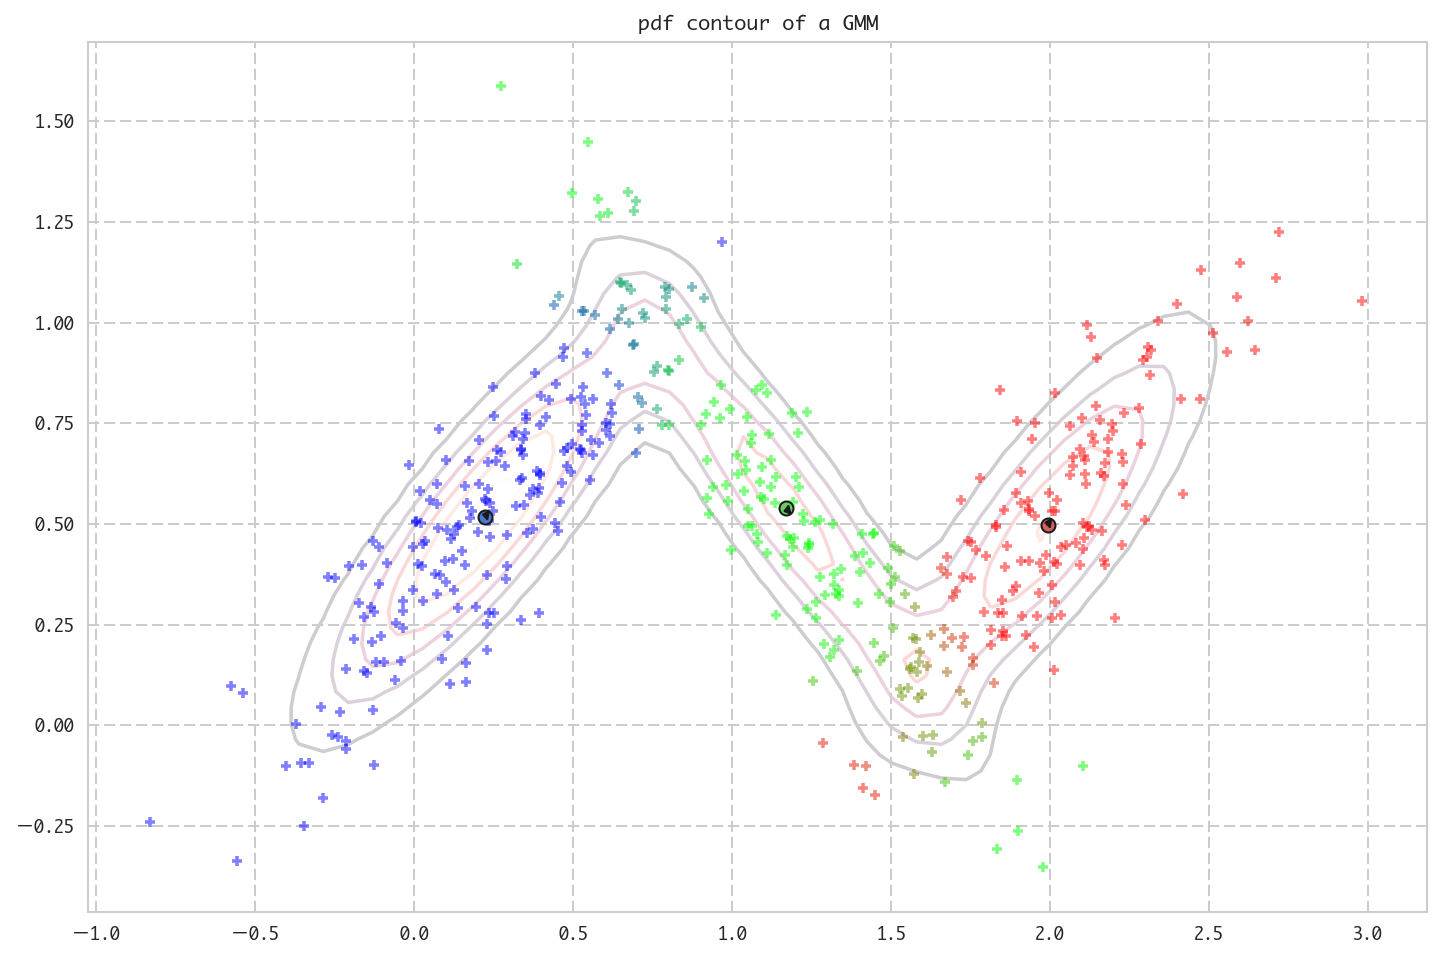

sum of log likelihood: -38831.3285979
diff: 0.0253908744053
pi: [ 0.31078853  0.29328083  0.39593064]
mu: [[ 1.99195373  0.49733799]
 [ 1.17045087  0.53905302]
 [ 0.22298853  0.51729472]]
sigma: [[[ 0.08604223  0.07103674]
  [ 0.07103674  0.08601501]]

 [[ 0.12168699 -0.1184902 ]
  [-0.1184902   0.13718196]]

 [[ 0.09987283  0.08195568]
  [ 0.08195568  0.09101209]]]


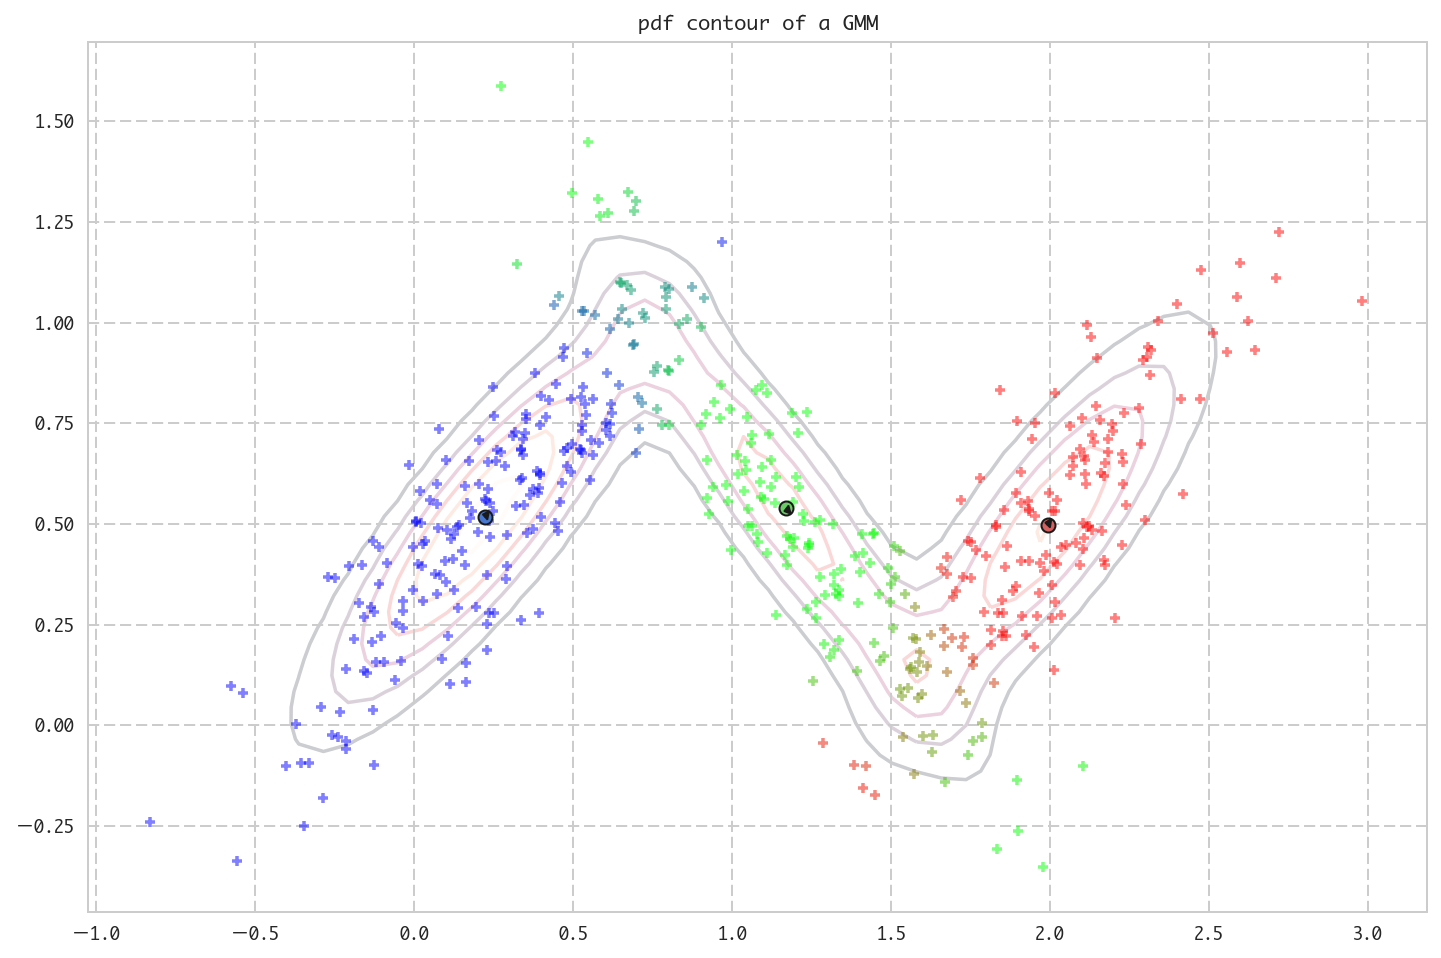

sum of log likelihood: -38831.3426733
diff: 0.0140753926389
pi: [ 0.31078849  0.2932802   0.39593131]
mu: [[ 1.99195379  0.49733807]
 [ 1.1704521   0.53905183]
 [ 0.22298928  0.51729557]]
sigma: [[[ 0.08604222  0.07103672]
  [ 0.07103672  0.08601499]]

 [[ 0.12168664 -0.11848993]
  [-0.11848993  0.13718173]]

 [[ 0.09987302  0.08195591]
  [ 0.08195591  0.09101239]]]


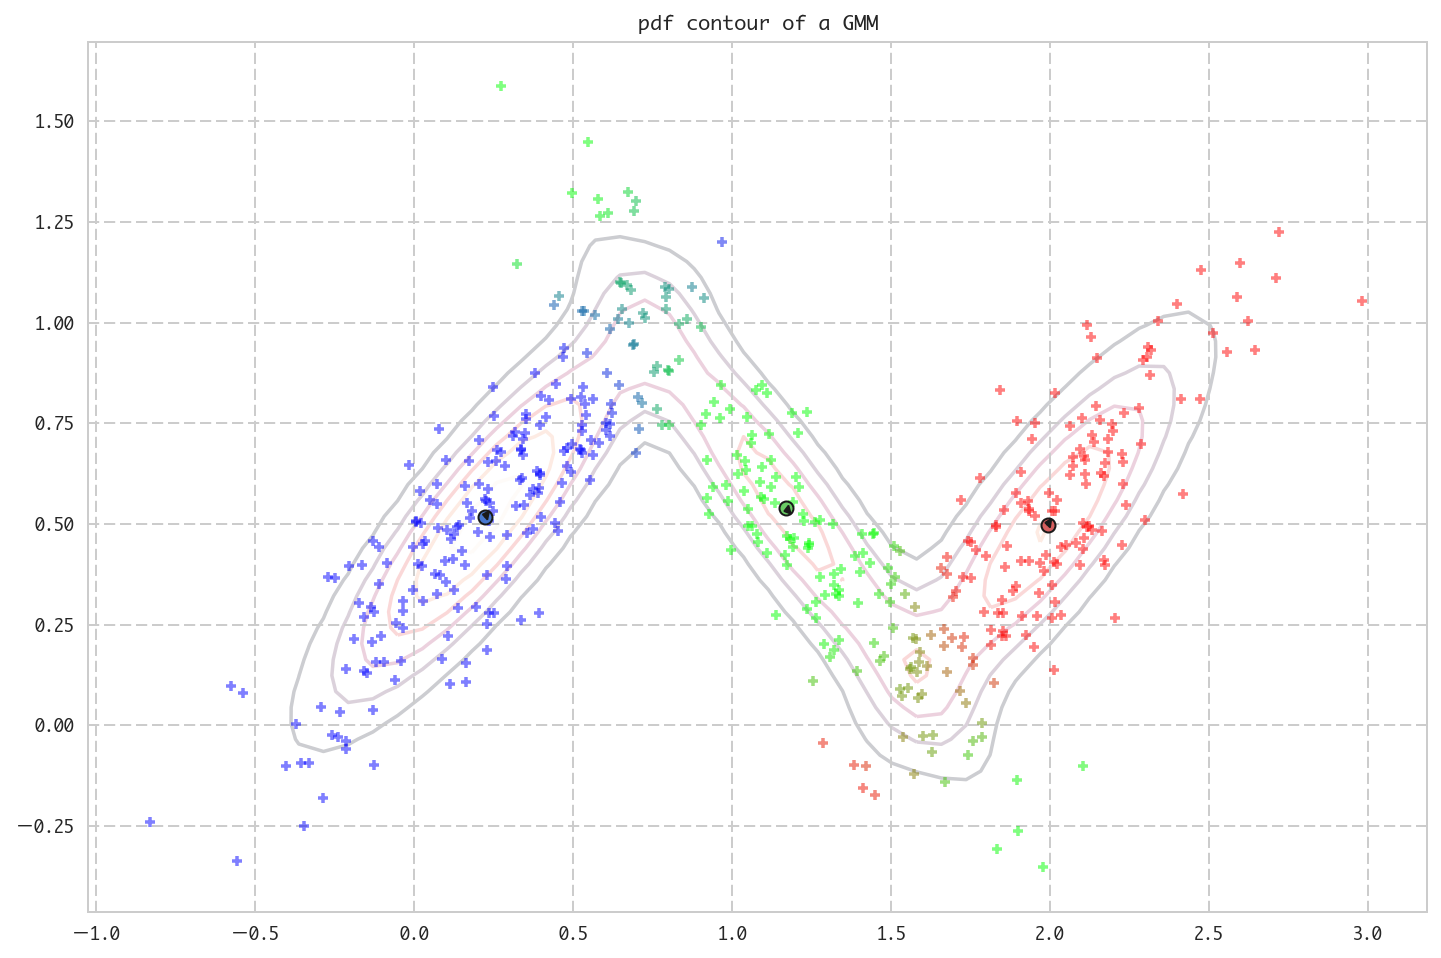

sum of log likelihood: -38831.3504811
diff: 0.00780781071808
pi: [ 0.31078846  0.29327985  0.39593169]
mu: [[ 1.99195382  0.49733811]
 [ 1.17045279  0.53905117]
 [ 0.22298969  0.51729604]]
sigma: [[[ 0.08604222  0.07103671]
  [ 0.07103671  0.08601497]]

 [[ 0.12168644 -0.11848978]
  [-0.11848978  0.1371816 ]]

 [[ 0.09987312  0.08195604]
  [ 0.08195604  0.09101257]]]


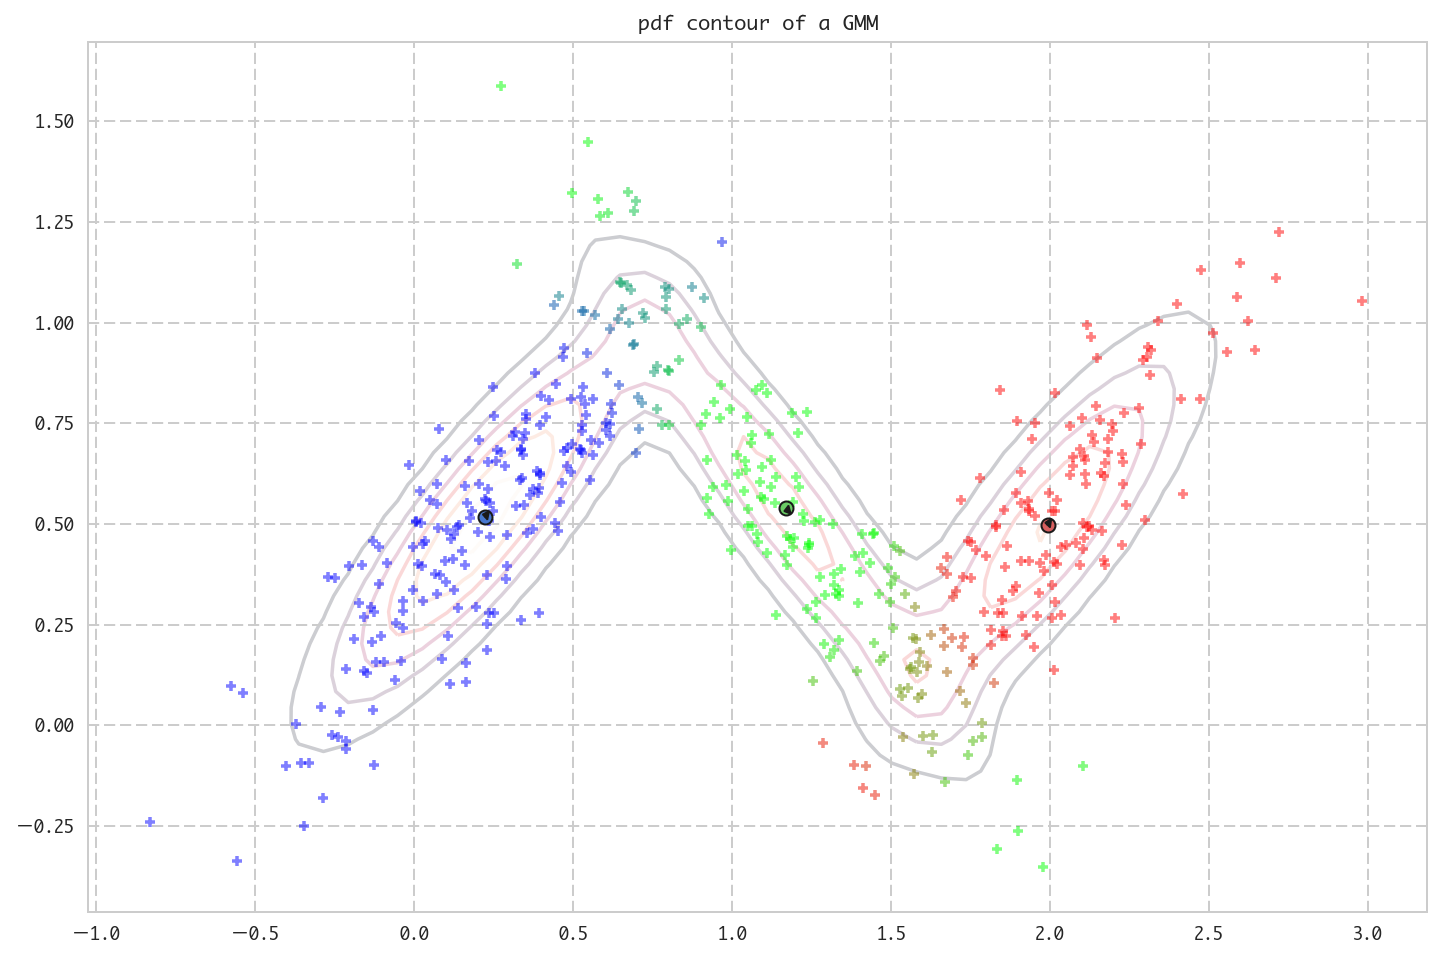

sum of log likelihood: -38831.3548144
diff: 0.00433331728709
pi: [ 0.31078845  0.29327965  0.3959319 ]
mu: [[ 1.99195384  0.49733813]
 [ 1.17045317  0.53905081]
 [ 0.22298992  0.51729631]]
sigma: [[[ 0.08604221  0.07103671]
  [ 0.07103671  0.08601496]]

 [[ 0.12168633 -0.1184897 ]
  [-0.1184897   0.13718153]]

 [[ 0.09987318  0.08195611]
  [ 0.08195611  0.09101266]]]


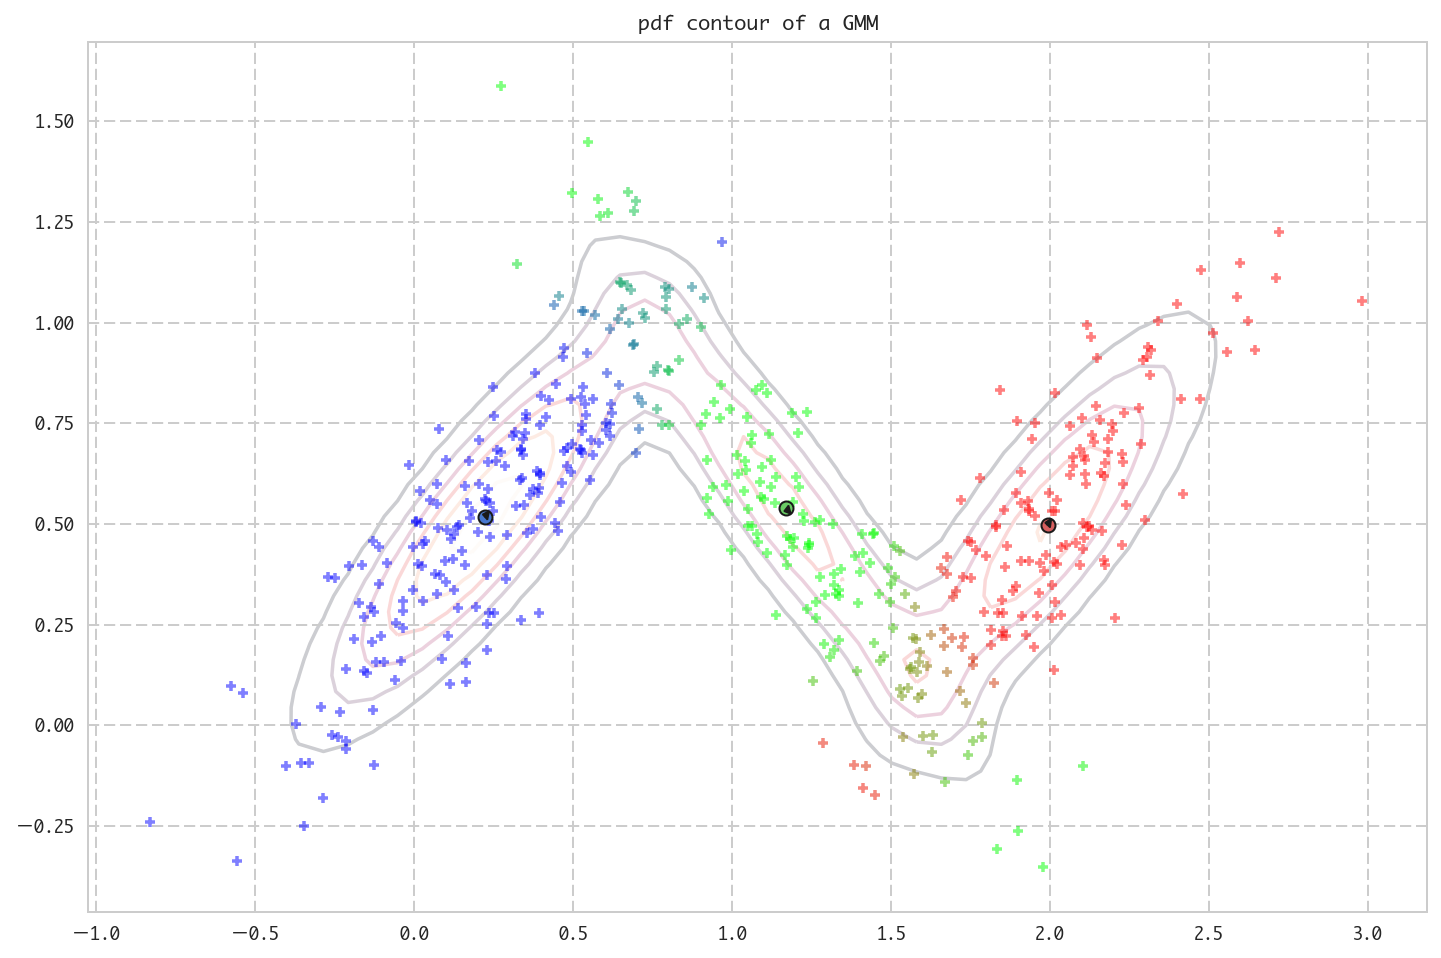

sum of log likelihood: -38831.3572204
diff: 0.00240596282674
pi: [ 0.31078845  0.29327954  0.39593201]
mu: [[ 1.99195385  0.49733814]
 [ 1.17045338  0.53905061]
 [ 0.22299005  0.51729645]]
sigma: [[[ 0.08604221  0.0710367 ]
  [ 0.0710367   0.08601496]]

 [[ 0.12168626 -0.11848965]
  [-0.11848965  0.13718149]]

 [[ 0.09987321  0.08195615]
  [ 0.08195615  0.09101271]]]


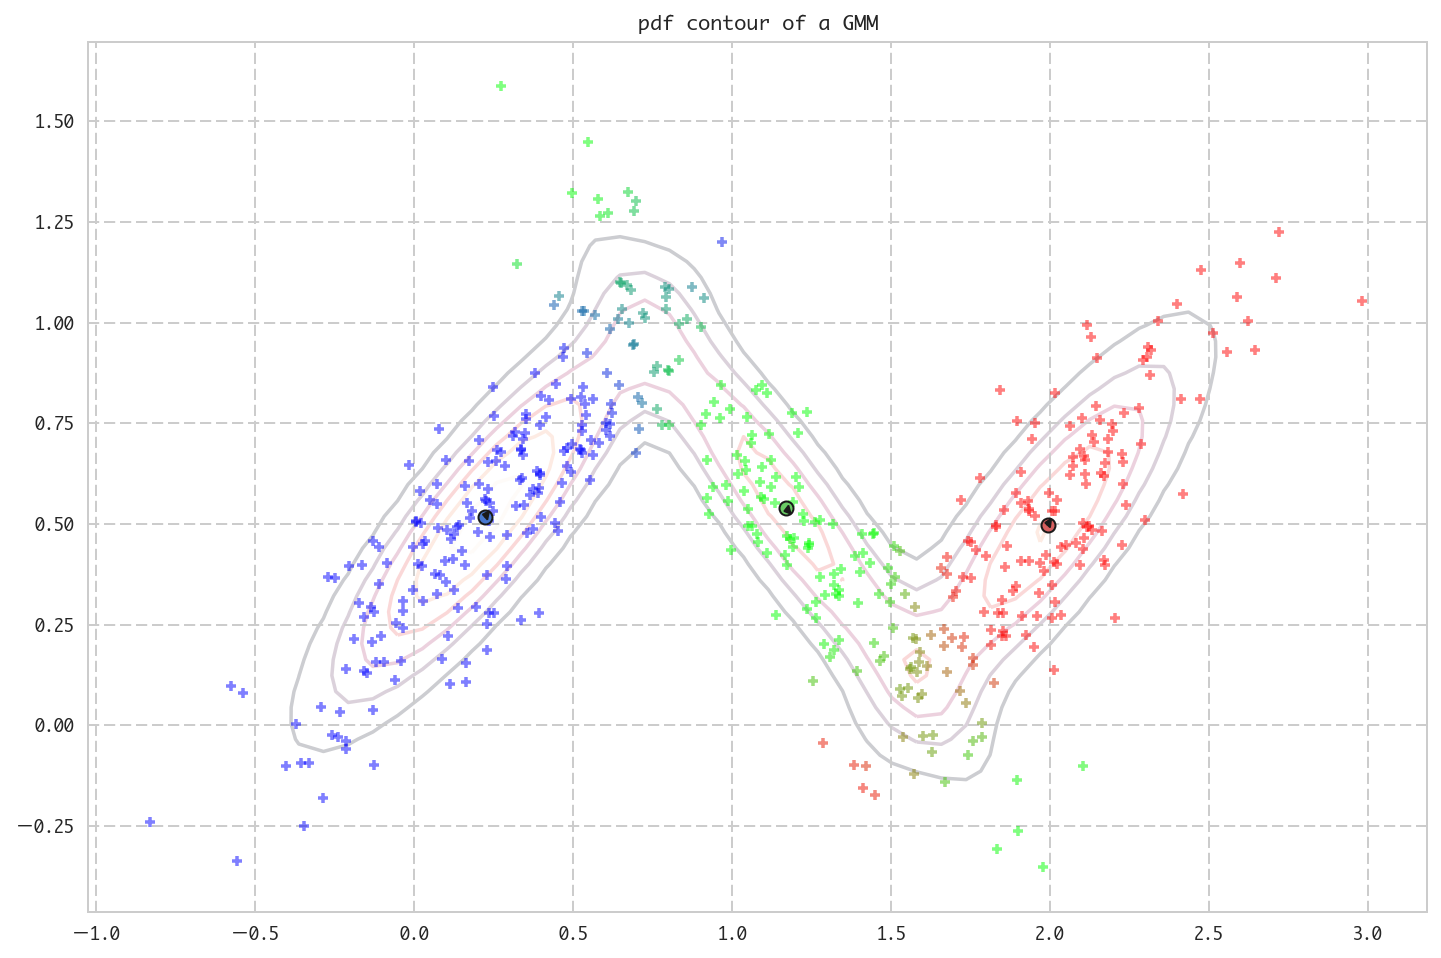

sum of log likelihood: -38831.3585567
diff: 0.00133629435732
pi: [ 0.31078844  0.29327948  0.39593208]
mu: [[ 1.99195385  0.49733815]
 [ 1.1704535   0.53905049]
 [ 0.22299012  0.51729654]]
sigma: [[[ 0.08604221  0.0710367 ]
  [ 0.0710367   0.08601496]]

 [[ 0.12168623 -0.11848962]
  [-0.11848962  0.13718146]]

 [[ 0.09987323  0.08195617]
  [ 0.08195617  0.09101274]]]


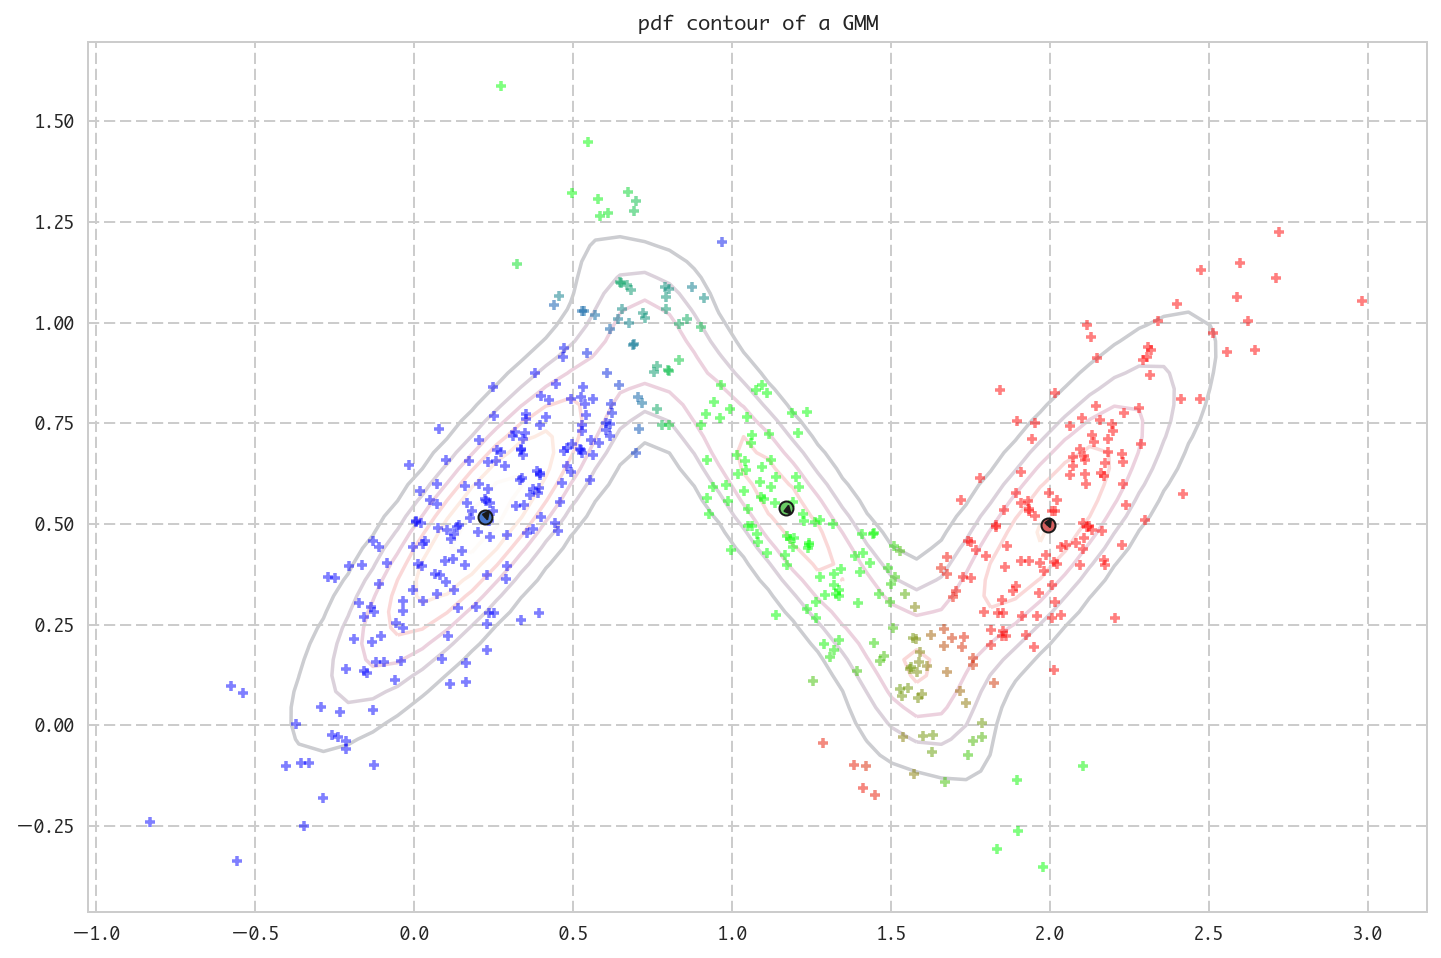

sum of log likelihood: -38831.3592991
diff: 0.000742396056012
pi: [ 0.31078844  0.29327945  0.39593211]
mu: [[ 1.99195385  0.49733815]
 [ 1.17045356  0.53905043]
 [ 0.22299016  0.51729658]]
sigma: [[[ 0.08604221  0.0710367 ]
  [ 0.0710367   0.08601496]]

 [[ 0.12168621 -0.11848961]
  [-0.11848961  0.13718145]]

 [[ 0.09987324  0.08195618]
  [ 0.08195618  0.09101276]]]


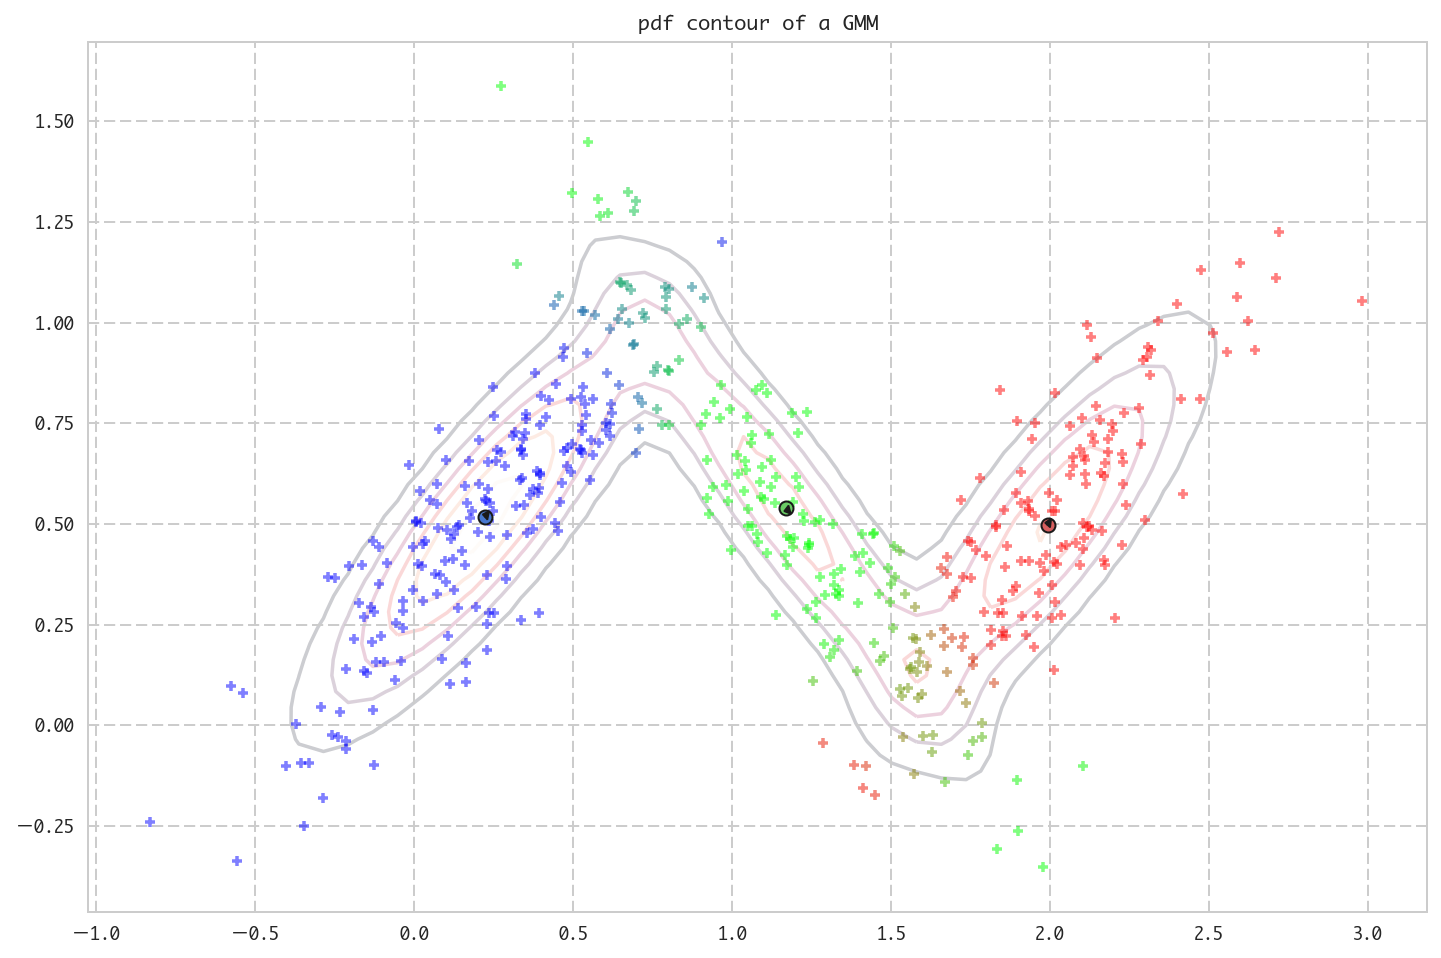

sum of log likelihood: -38831.3597116
diff: 0.000412545363361
pi: [ 0.31078844  0.29327943  0.39593213]
mu: [[ 1.99195386  0.49733816]
 [ 1.1704536   0.53905039]
 [ 0.22299019  0.51729661]]
sigma: [[[ 0.08604221  0.0710367 ]
  [ 0.0710367   0.08601496]]

 [[ 0.1216862  -0.1184896 ]
  [-0.1184896   0.13718144]]

 [[ 0.09987325  0.08195619]
  [ 0.08195619  0.09101277]]]


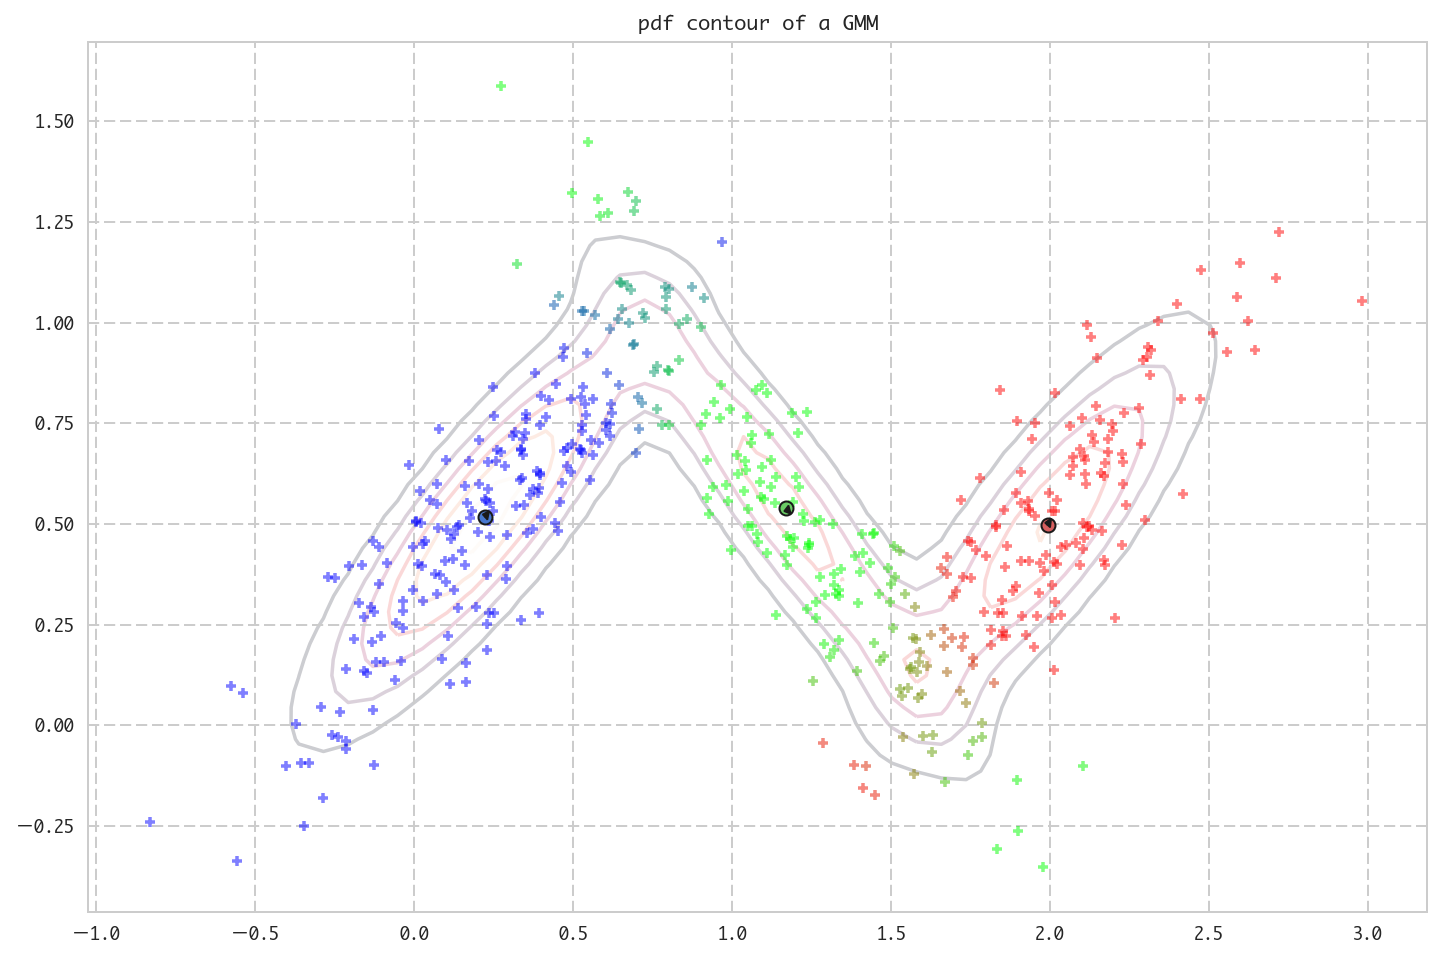

sum of log likelihood: -38831.3599409
diff: 0.000229295539611
pi: [ 0.31078844  0.29327942  0.39593214]
mu: [[ 1.99195386  0.49733816]
 [ 1.17045362  0.53905037]
 [ 0.2229902   0.51729662]]
sigma: [[[ 0.08604221  0.0710367 ]
  [ 0.0710367   0.08601496]]

 [[ 0.12168619 -0.1184896 ]
  [-0.1184896   0.13718144]]

 [[ 0.09987325  0.08195619]
  [ 0.08195619  0.09101277]]]


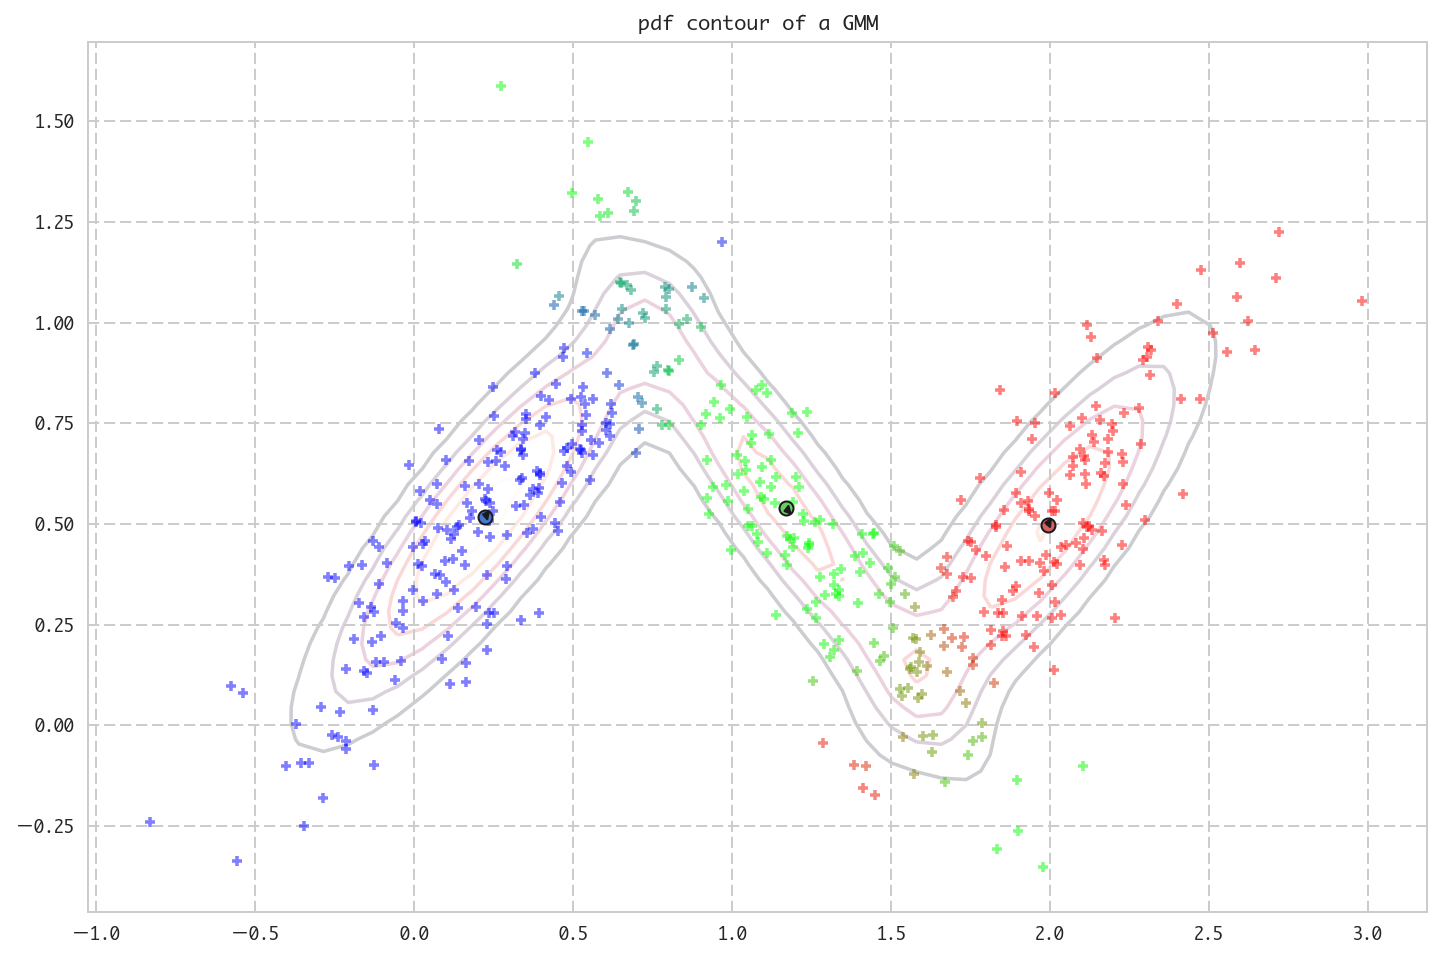

sum of log likelihood: -38831.3600684
diff: 0.000127466890262
pi: [ 0.31078844  0.29327941  0.39593215]
mu: [[ 1.99195386  0.49733816]
 [ 1.17045363  0.53905036]
 [ 0.22299021  0.51729663]]
sigma: [[[ 0.08604221  0.0710367 ]
  [ 0.0710367   0.08601496]]

 [[ 0.12168619 -0.11848959]
  [-0.11848959  0.13718144]]

 [[ 0.09987325  0.0819562 ]
  [ 0.0819562   0.09101278]]]


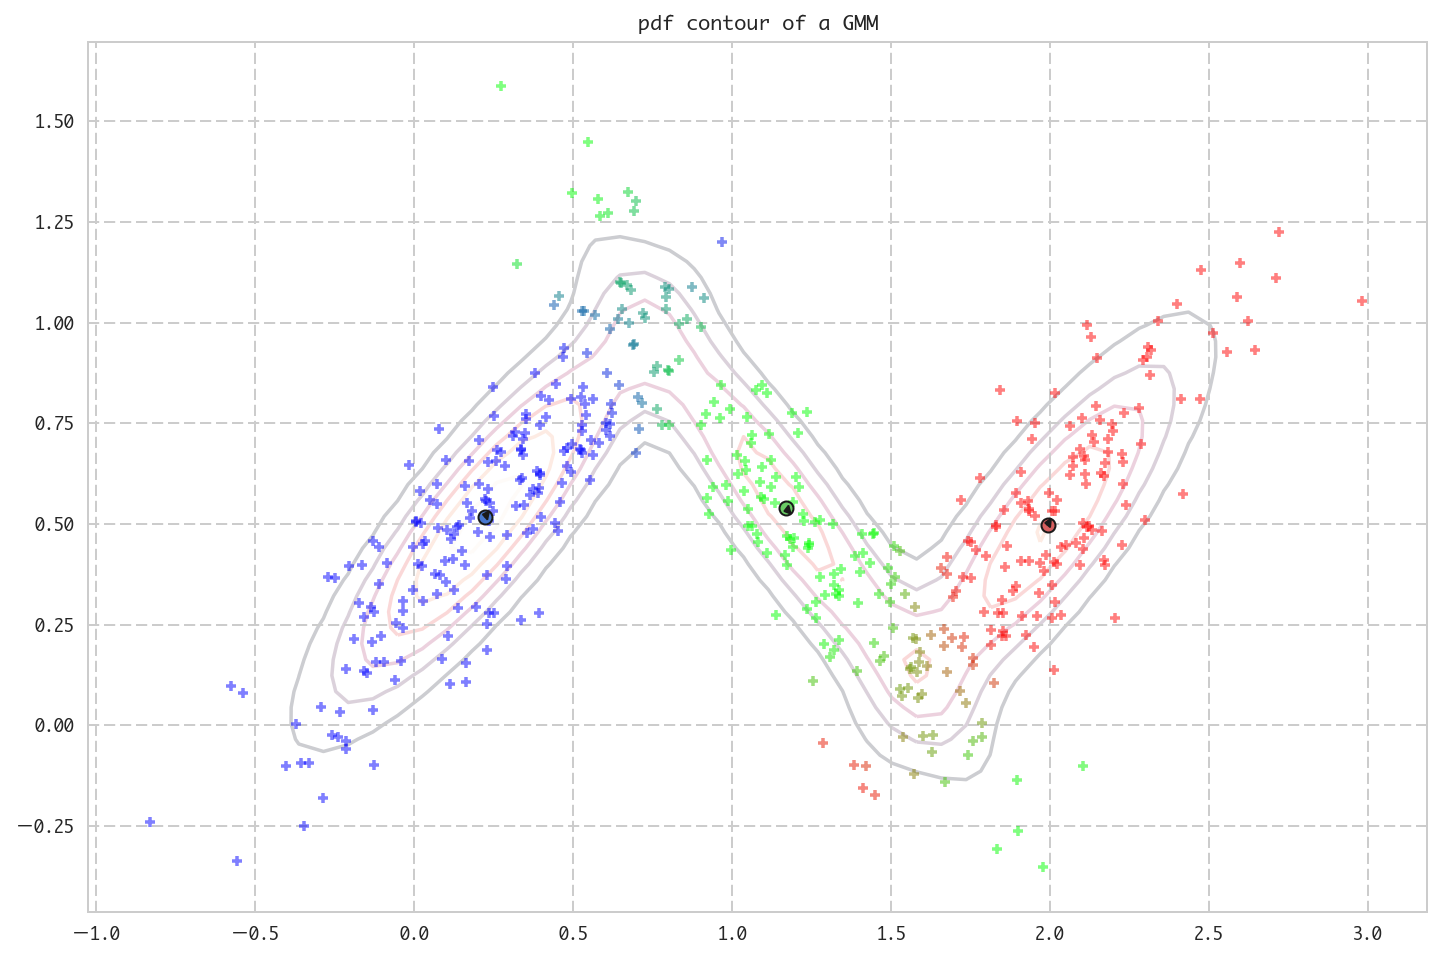

sum of log likelihood: -38831.3601393
diff: 7.08706502337e-05
pi: [ 0.31078844  0.29327941  0.39593215]
mu: [[ 1.99195386  0.49733816]
 [ 1.17045364  0.53905036]
 [ 0.22299021  0.51729663]]
sigma: [[[ 0.08604221  0.0710367 ]
  [ 0.0710367   0.08601496]]

 [[ 0.12168619 -0.11848959]
  [-0.11848959  0.13718144]]

 [[ 0.09987325  0.0819562 ]
  [ 0.0819562   0.09101278]]]


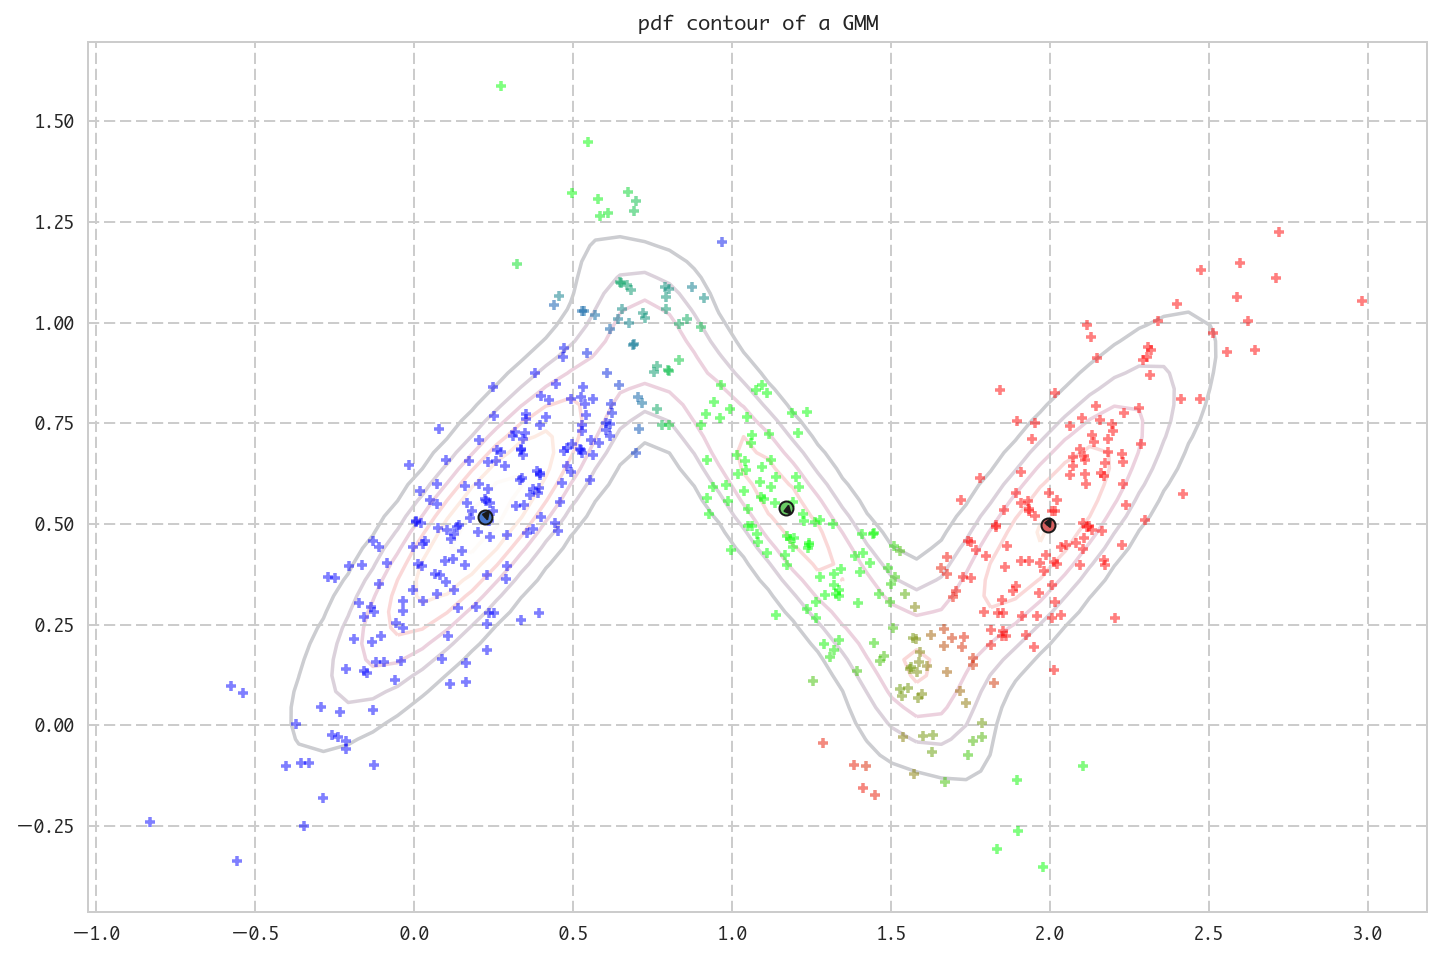

likelihood is converged.


In [5]:
for step in range(100):
    # E step ========================================================================
    # calculate responsibility(負担率)
    likelihood = calc_likelihood(data, mu, sigma, pi, K)
    #gamma = np.apply_along_axis(lambda x: [xx/np.sum(x) for xx in x] , 1, likelihood)
    gamma = (likelihood.T/np.sum(likelihood, axis=1)).T
    N_k = [np.sum(gamma[:,k]) for k in range(K)]

    # M step ========================================================================

    # caluculate pi
    pi =  N_k/N

    # calculate mu
    tmp_mu = np.zeros((K, D))

    for k in range(K):
        for i in range(len(data)):
            tmp_mu[k] += gamma[i, k]*data[i]
        tmp_mu[k] = tmp_mu[k]/N_k[k]
        #print('updated mu[{}]:\n'.format(k) , tmp_mu[k])
    mu_prev = mu.copy()
    mu = tmp_mu.copy()
    #print('updated mu:\n', mu)

    # calculate sigma
    tmp_sigma = np.zeros((K, D, D))

    for k in range(K):
        tmp_sigma[k] = np.zeros((D, D))
        for i in range(N):
            tmp = np.asanyarray(data[i]-mu[k])[:,np.newaxis]
            tmp_sigma[k] += gamma[i, k]*np.dot(tmp, tmp.T)
        tmp_sigma[k] = tmp_sigma[k]/N_k[k]

        #print('updated sigma[{}]:\n'.format(k) , tmp_sigma[k])
    sigma = tmp_sigma.copy()

    # calculate likelihood
    prev_likelihood = likelihood
    likelihood = calc_likelihood(data, mu, sigma, pi, K)
    
    prev_sum_log_likelihood = np.sum(np.log(prev_likelihood))
    sum_log_likelihood = np.sum(np.log(likelihood))
    diff = prev_sum_log_likelihood - sum_log_likelihood
    
    print('sum of log likelihood:', sum_log_likelihood)
    print('diff:', diff)

    print('pi:', pi)
    print('mu:', mu)
    print('sigma:', sigma)

    # visualize
    plt.figure(figsize=(12,8))
    for i in range(N):
        plt.scatter(data[i,0], data[i,1], s=30, c=gamma[i], alpha=0.5, marker="+")

    for i in range(K):
        ax = plt.axes()
        ax.arrow(mu_prev[i, 0], mu_prev[i, 1], mu[i, 0]-mu_prev[i, 0], mu[i, 1]-mu_prev[i, 1],
                  lw=0.8, head_width=0.02, head_length=0.02, fc='k', ec='k')
        plt.scatter([mu_prev[i, 0]], [mu_prev[i, 1]], c=c[i], marker='o', alpha=0.8)
        plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o', edgecolors='k', linewidths=1)
        #plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
    plt.title("step:{}".format(step))
    
    print_gmm_contour(mu, sigma, pi, K)
    plt.show()
    
    if np.abs(diff) < 0.0001:
        print('likelihood is converged.')
        break